# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [13]:
import numpy as np
import os
import skimage
from skimage import transform
import datetime
import os
import pandas as pd
import random
from skimage.filters import gaussian
from skimage.util import random_noise
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

%pip install imgaug
import imgaug as ia
from imgaug import augmenters as iaa

Note: you may need to restart the kernel to use updated packages.


We set the random seed so that the results don't vary drastically.

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
import random as rn
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)
%matplotlib inline


# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


sns.set_style(style='dark')
sns.set_context("notebook")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [32]:
batch_size = 10
base_path = 'Project_data/'

In [33]:
train_doc = np.random.permutation(open(base_path+'train.csv').readlines())
val_doc = np.random.permutation(open(base_path + 'val.csv').readlines())

# Explore Data

In [34]:
def read_data(source):
    df = pd.read_csv(source, header=None)
    df[['folder', 'name', 'class']] = df[0].str.split(';', expand=True)
    return df

In [35]:
def explore_data(source):
    df = read_data(source)
    print(df['class'].value_counts())

In [36]:
# Train data
explore_data(base_path+'train.csv')

3    137
1    137
0    136
2    130
4    123
Name: class, dtype: int64


In [37]:
# Val data
explore_data(base_path+'val.csv')

1    23
2    22
3    21
0    18
4    16
Name: class, dtype: int64


We can see that data is evenly balance across all the classes.

In [38]:
def get_image(folder, index):
    image_name = os.listdir(folder)[index]
    image = skimage.io.imread(folder + "/" + image_name).astype(np.float32)
    return image

In [39]:
def get_image_dimensions(row, source_path):
    y, x, _ = get_image(source_path + row['folder'], 0).shape
    return str(x) + "-" + str(y)

In [40]:
def explore_images(source_file, source_path):
    df = read_data(source_file)
    df['shape'] = df.apply(get_image_dimensions, axis=1, args=[source_path])
    print(df['shape'].value_counts())
    return df

In [41]:
# Exploring Train images
explore_images(base_path+'train.csv', base_path+'train/')

160-120    479
360-360    184
Name: shape, dtype: int64


0  \
0    WIN_20180925_17_08_43_Pro_Left_Swipe_new;Left_...   
1    WIN_20180925_17_18_28_Pro_Left_Swipe_new;Left_...   
2    WIN_20180925_17_18_56_Pro_Left_Swipe_new;Left_...   
3    WIN_20180925_17_19_51_Pro_Left_Swipe_new;Left_...   
4    WIN_20180925_17_20_14_Pro_Left_Swipe_new;Left_...   
5    WIN_20180925_17_21_28_Pro_Left_Swipe_new;Left_...   
6    WIN_20180925_17_22_55_Pro_Left_Swipe_new;Left_...   
7    WIN_20180925_17_24_49_Pro_Left_Swipe_new;Left_...   
8    WIN_20180925_17_26_25_Pro_Left_Swipe_new;Left_...   
9    WIN_20180925_17_26_51_Pro_Left_Swipe_new;Left_...   
10   WIN_20180925_17_27_40_Pro_Left_Swipe_new;Left_...   
11   WIN_20180925_17_29_52_Pro_Left_Swipe_new;Left_...   
12   WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_...   
13   WIN_20180925_17_35_39_Pro_Left_Swipe_new;Left_...   
14   WIN_20180925_17_37_08_Pro_Left_Swipe_new;Left_...   
15   WIN_20180925_17_37_30_Pro_Left_Swipe_new;Left_...   
16   WIN_20180925_17_39_25_Pro_Left_Swipe_new;Left_...   
17   WIN_20180925_17_40_41_Pro_Left_Swipe_new;Left_...   
18   WIN_20180925_17_43_32_Pro_Left_Swipe_new;Left_...   
19   WIN_20180925_17_43_57_Pro_Left_Swipe_new;Left_...   
20   WIN_20180925_17_46_20_Pro_Left_Swipe_new;Left_...   
21   WIN_20180925_17_46_39_Pro_Left_Swipe_new;Left_...   
22   WIN_20180925_17_46_49_Pro_Left_Swipe_new;Left_...   
23   WIN_20180925_17_48_24_Pro_Left_Swipe_new;Left_...   
24   WIN_20180925_17_49_07_Pro_Left_Swipe_new;Left_...   
25   WIN_20180925_17_49_29_Pro_Left_Swipe_new;Left_...   
26   WIN_20180925_17_50_44_Pro_Left_Swipe_new;Left_...   
27   WIN_20180925_17_51_26_Pro_Left_Swipe_new;Left_...   
28   WIN_20180925_17_51_49_Pro_Left_Swipe_new;Left_...   
29   WIN_20180925_17_52_20_Pro_Left_Swipe_new;Left_...   
30   WIN_20180925_17_52_58_Pro_Left_Swipe_new;Left_...   
31   WIN_20180925_17_54_25_Pro_Left_Swipe_new;Left_...   
32   WIN_20180925_17_55_12_Pro_Left_Swipe_new;Left_...   
33   WIN_20180925_17_55_57_Pro_Left_Swipe_new;Left_...   
34   WIN_20180925_17_57_36_Pro_Left_Swipe_new;Left_...   
35   WIN_20180925_18_01_57_Pro_Left_Swipe_new;Left_...   
36   WIN_20180925_18_02_17_Pro_Left_Swipe_new;Left_...   
37   WIN_20180925_18_06_22_Pro_Left_Swipe_new;Left_...   
38   WIN_20180925_18_07_19_Pro_Left_Swipe_new;Left_...   
39   WIN_20180925_18_07_47_Pro_Left_Swipe_new;Left_...   
40   WIN_20180926_16_44_06_Pro_Left_Swipe_new;Left_...   
41   WIN_20180926_16_44_37_Pro_Left_Swipe_new;Left_...   
42   WIN_20180926_16_45_15_Pro_Left_Swipe_new;Left_...   
43   WIN_20180926_16_46_40_Pro_Left_Swipe_new;Left_...   
44   WIN_20180926_16_48_34_Pro_Left_Swipe_new;Left_...   
45   WIN_20180926_16_49_15_Pro_Left_Swipe_new;Left_...   
46   WIN_20180926_16_49_52_Pro_Left_Swipe_new;Left_...   
47   WIN_20180926_16_50_21_Pro_Left_Swipe_new;Left_...   
48   WIN_20180926_16_51_55_Pro_Left_Swipe_new;Left_...   
49   WIN_20180926_16_52_38_Pro_Left_Swipe_new;Left_...   
50   WIN_20180926_16_54_30_Pro_Left_Swipe_new;Left_...   
51   WIN_20180926_16_54_48_Pro_Left_Swipe_new;Left_...   
52   WIN_20180926_16_55_41_Pro_Left_Swipe_new;Left_...   
53   WIN_20180926_16_57_26_Pro_Left_Swipe_new;Left_...   
54   WIN_20180926_16_57_34_Pro_Left_Swipe_new;Left_...   
55   WIN_20180926_16_58_12_Pro_Left_Swipe_new;Left_...   
56   WIN_20180926_16_59_06_Pro_Left_Swipe_new;Left_...   
57   WIN_20180926_17_00_32_Pro_Left_Swipe_new;Left_...   
58   WIN_20180926_17_03_21_Pro_Left_Swipe_new;Left_...   
59   WIN_20180926_17_05_08_Pro_Left_Swipe_new;Left_...   
60   WIN_20180926_17_05_27_Pro_Left_Swipe_new;Left_...   
61   WIN_20180926_17_06_12_Pro_Left_Swipe_new;Left_...   
62   WIN_20180926_17_06_24_Pro_Left_Swipe_new;Left_...   
63   WIN_20180926_17_07_09_Pro_Left_Swipe_new;Left_...   
64   WIN_20180926_17_10_21_Pro_Left_Swipe_new;Left_...   
65   WIN_20180926_17_11_11_Pro_Left_Swipe_new;Left_...   
66   WIN_20180926_17_11_41_Pro_Left_Swipe_new;Left_...   
67   WIN_20180926_17_12_37_Pro_Left_Swipe_new;Left_...   
68   WIN_20180926_17_13_07_Pro_Left_Swipe_new;Left_

In [42]:
# Exploring Val images
explore_images(base_path+'val.csv', base_path+'val/')

160-120    62
360-360    38
Name: shape, dtype: int64


0  \
0   WIN_20180925_17_17_04_Pro_Left_Swipe_new;Left_...   
1   WIN_20180925_17_43_01_Pro_Left_Swipe_new;Left_...   
2   WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_...   
3   WIN_20180925_18_03_21_Pro_Left_Swipe_new;Left_...   
4   WIN_20180926_16_46_22_Pro_Left_Swipe_new;Left_...   
5   WIN_20180926_16_47_09_Pro_Left_Swipe_new;Left_...   
6   WIN_20180926_17_05_38_Pro_Left_Swipe_new;Left_...   
7   WIN_20180926_17_08_09_Pro_Left_Swipe_new;Left_...   
8   WIN_20180926_17_09_33_Pro_Left_Swipe_new;Left_...   
9   WIN_20180926_17_15_35_Pro_Left_Swipe_new;Left_...   
10  WIN_20180926_17_21_48_Pro_Left_Swipe_new;Left_...   
11  WIN_20180926_17_32_55_Pro_Left_Swipe_new;Left_...   
12  WIN_20180926_17_40_21_Pro_Left_Swipe_new;Left_...   
13  WIN_20180925_17_25_06_Pro_Right_Swipe_new;Righ...   
14  WIN_20180925_17_43_46_Pro_Right_Swipe_new;Righ...   
15  WIN_20180926_16_48_40_Pro_Right_Swipe_new;Righ...   
16  WIN_20180926_16_52_49_Pro_Right_Swipe_new;Righ...   
17  WIN_20180926_17_01_52_Pro_Right_Swipe_new;Righ...   
18  WIN_20180926_17_03_57_Pro_Right_Swipe_new;Righ...   
19  WIN_20180926_17_12_27_Pro_Right_Swipe_new;Righ...   
20  WIN_20180926_17_24_12_Pro_Right_Swipe_new;Righ...   
21  WIN_20180926_17_29_34_Pro_Right_Swipe_new;Righ...   
22  WIN_20180926_17_33_14_Pro_Right_Swipe_new;Righ...   
23  WIN_20180926_17_34_05_Pro_Right_Swipe_new;Righ...   
24  WIN_20180926_17_35_34_Pro_Right_Swipe_new;Righ...   
25  WIN_20180926_17_56_52_Pro_Right_Swipe_new;Righ...   
26      WIN_20180925_17_30_40_Pro_Stop_new;Stop_new;2   
27      WIN_20180925_17_32_32_Pro_Stop_new;Stop_new;2   
28      WIN_20180925_17_40_03_Pro_Stop_new;Stop_new;2   
29      WIN_20180925_17_49_40_Pro_Stop_new;Stop_new;2   
30      WIN_20180925_17_52_42_Pro_Stop_new;Stop_new;2   
31      WIN_20180926_16_37_56_Pro_Stop_new;Stop_new;2   
32      WIN_20180926_16_47_44_Pro_Stop_new;Stop_new;2   
33      WIN_20180926_16_48_48_Pro_Stop_new;Stop_new;2   
34      WIN_20180926_17_04_53_Pro_Stop_new;Stop_new;2   
35      WIN_20180926_17_08_11_Pro_Stop_new;Stop_new;2   
36      WIN_20180926_17_32_15_Pro_Stop_new;Stop_new;2   
37      WIN_20180926_17_32_40_Pro_Stop_new;Stop_new;2   
38      WIN_20180926_17_33_14_Pro_Stop_new;Stop_new;2   
39      WIN_20180926_17_33_49_Pro_Stop_new;Stop_new;2   
40  WIN_20180925_17_33_30_Pro_Thumbs_Down_new;Thum...   
41  WIN_20180925_17_35_29_Pro_Thumbs_Down_new;Thum...   
42  WIN_20180925_17_48_16_Pro_Thumbs_Down_new;Thum...   
43  WIN_20180925_17_50_24_Pro_Thumbs_Down_new;Thum...   
44  WIN_20180926_16_44_04_Pro_Thumbs_Down_new;Thum...   
45  WIN_20180926_16_57_50_Pro_Thumbs_Down_new;Thum...   
46  WIN_20180926_17_05_38_Pro_Thumbs_Down_new;Thum...   
47  WIN_20180926_17_09_45_Pro_Thumbs_Down_new;Thum...   
48  WIN_20180926_17_13_25_Pro_Thumbs_Down_new;Thum...   
49  WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thum...   
50  WIN_20180926_17_34_23_Pro_Thumbs_Down_new;Thum...   
51  WIN_20180926_17_44_14_Pro_Thumbs_Down_new;Thum...   
52  WIN_20180925_17_35_04_Pro_Thumbs_Up_new;Thumbs...   
53  WIN_20180925_17_38_43_Pro_Thumbs_Up_new;Thumbs...   
54  WIN_20180925_17_42_34_Pro_Thumbs_Up_new;Thumbs...   
55  WIN_20180925_17_47_07_Pro_Thumbs_Up_new;Thumbs...   
56  WIN_20180925_17_58_08_Pro_Thumbs_Up_new;Thumbs...   
57  WIN_20180925_17_59_48_Pro_Thumbs_Up_new;Thumbs...   
58  WIN_20180926_16_43_34_Pro_Thumbs_Up_new;Thumbs...   
59  WIN_20180926_17_06_40_Pro_Thumbs_Up_new;Thumbs...   
60  WIN_20180926_17_14_26_Pro_Thumbs_Up_new;Thumbs...   
61  WIN_20180926_17_28_32_Pro_Thumbs_Up_new;Thumbs...   
62  WIN_20180907_15_45_04_Pro_Left Swipe_new_Left ...   
63  WIN_20180907_16_00_42_Pro_Left Swipe_new_Left ...   
64  WIN_20180907_16_05_32_Pro_Left Swipe_new_Left ...   
65  WIN_20180907_16_21_39_Pro_Left Swipe_new_Left ...   
66  WIN_20180907_16_36_42_Pro_Left Swipe_new_Left ...   
67  WIN_20180907_15_30_06_Pro_Right Swipe_new;Righ...   
68  WIN_20180907_15_45_43_Pro_Right Swipe_new;Righ...   
69  WIN_20180907_15_50_39_Pro_Right Swipe_new;Righ...   
70  W

We can see there are two dimensions of the images **160*120** and **360*360**. We will need to bring the images to same dimension when passing from generator.

## We will resize the bigger image to 120X120 and smaller will be cropped to 120X120

In [167]:
starting_image_shape = (120, 120)

Reference 
- https://medium.com/@ODSC/image-augmentation-for-convolutional-neural-networks-18319e1291c
- https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/
- https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/

In [168]:
ia.seed(4)

In [223]:
def flip(image):
    return np.fliplr(image)

In [169]:
def rotate(image):
    return transform.rotate(image,random.uniform(-10,10))

In [170]:
def blur(image):
    return gaussian(image, sigma=1, multichannel=True)

In [171]:
def noise(image):
    return random_noise(image, var=0.1**2)

In [201]:
def scale(image):
    scale_image = iaa.PerspectiveTransform(scale=(0.01, 0.10))
    return scale_image(image=image)

In [173]:
def resize_image(image,image_shape):
    return transform.resize(image, image_shape)

In [219]:
image_augmentors = [rotate, blur, noise, scale, flip]
#image_augmentors = [scale]

In [176]:
def crop(image):
    return image[0:120, 20:140]

In [177]:
def modify_image(image, image_shape):
    if (image.shape[0] == image.shape[1]):
        return resize_image(image, image_shape)
    else:
        return resize_image(crop(image), image_shape)

In [178]:
def crop_center(img, cropx, cropy):
    print(img.shape)
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]

## Show image with different image aumentations

160-120    479
360-360    184
Name: shape, dtype: int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


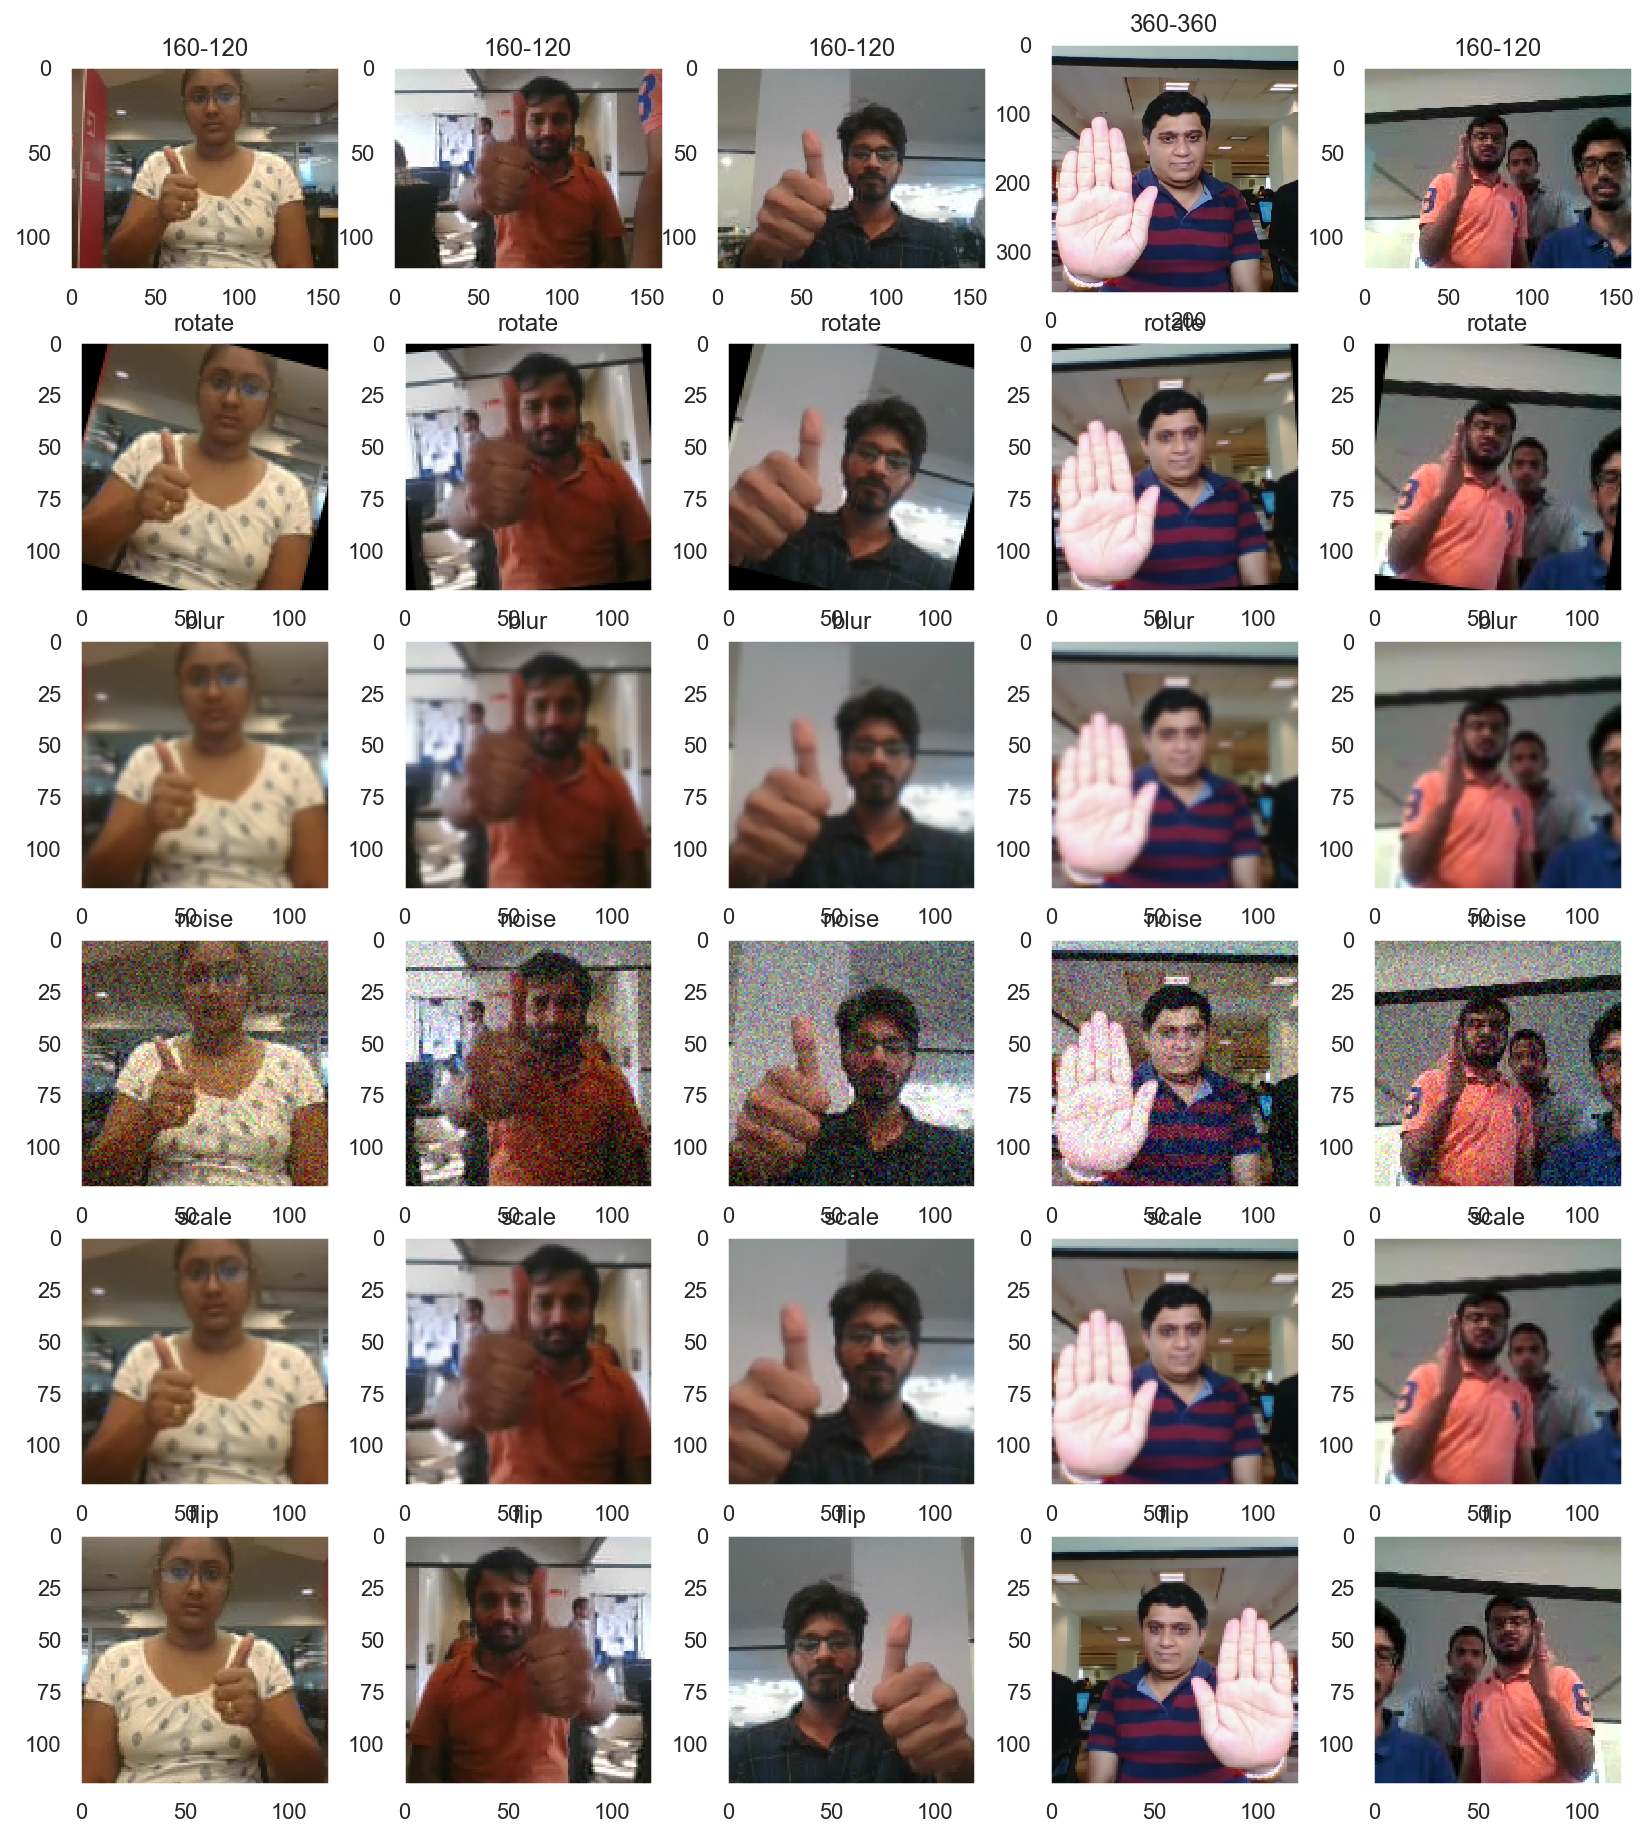

In [224]:
sample_size = 5
df = explore_images(base_path + 'train.csv', base_path + 'train/')
sample = df.sample(n=sample_size)
fig, axs = plt.subplots(1 + len(image_augmentors),
                        sample_size,
                        figsize=(14, 16))
plot_index = 1
for index, row in sample.head(n=sample_size).iterrows():
    image = get_image(base_path + 'train/' + row['folder'], 5)
    plt.subplot(1 + len(image_augmentors),
                sample_size,
                plot_index,
                title=row['shape'])
    plt.imshow(image.astype('uint8'), interpolation='nearest')
    image = modify_image(image, starting_image_shape) / 255
    size = plot_index
    for i, image_augmentor in enumerate(image_augmentors):
        size = size + sample_size
        plt.subplot(1 + len(image_augmentors),
                    sample_size,
                    size,
                    title=image_augmentor.__name__)
        current_image = image_augmentor(image)
        plt.imshow(current_image, cmap=None)
    plot_index += 1

plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [139]:
train_path = base_path + 'train'
val_path = base_path + 'val'

In [140]:
def nomalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

In [214]:
# TODO Refactor this method to remove duplicate and pass flag to append image to processedImages

random.seed(30)


def generator(source_path,
              folder_list,
              batch_size,
              list_of_frames,
              image_shape,
              is_training,
              augmentors=[],
              test_generator=False,
              verbose=False,
              processedImages=[]):
    print('Source path = ', source_path, '; batch size =', batch_size)
    # create a list of image numbers you want to use for a particular video
    img_idx = list_of_frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # calculate the number of batches
        if verbose:
            print("Number of batches ", num_batches)
        for batch in range(
                num_batches):  # we iterate over the number of batches
            if verbose:
                print("Executing batch ", batch)
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros(
                (batch_size, len(img_idx), image_shape[0], image_shape[1], 3))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size, 5))
            for folder in range(batch_size):  # iterate over the batch_size
                if verbose:
                    print("Executing folder ", folder)
                # read all the images in the folder
                imgs = os.listdir(source_path + '/' +
                                  t[folder +
                                    (batch * batch_size)].split(';')[0])
                # Iterate iver the frames/images of a folder to read them in
                for idx, item in enumerate(img_idx):
                    if test_generator:
                        processedImages.append(
                            source_path + '/' +
                            t[folder +
                              (batch * batch_size)].strip().split(';')[0] +
                            "_" + str(item))
                    image = get_image(
                        source_path + '/' +
                        t[folder + (batch * batch_size)].strip().split(';')[0],
                        item)

                    # Here, we are croping and resizing the image based on its dimensions
                    image = modify_image(image, image_shape)
                    # normalize image
                    image = image / 255
                    if is_training and (len(augmentors) > 0):
                        augmentor = random.choice(augmentors)
                        if(augmentor.__name__ == flip.__name__):
                            
                        image = augmentor(image)
                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]

                batch_labels[folder,
                             int(t[folder +
                                   (batch *
                                    batch_size)].strip().split(';')[2])] = 1
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield batch_data, batch_labels

        remaining_folder = len(t) % batch_size
        if remaining_folder > 0:
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((remaining_folder, len(img_idx),
                                   image_shape[0], image_shape[1], 3))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((remaining_folder, 5))

            if verbose:
                print("Executing last batch ")
            for folder in range(
                    remaining_folder):  # iterate over the batch_size
                if verbose:
                    print("Executing folder ", folder)
                # read all the images in the folder
                imgs = os.listdir(source_path + '/' +
                                  t[folder +
                                    (num_batches * batch_size)].split(';')[0])
                # Iterate iver the frames/images of a folder to read them in
                for idx, item in enumerate(img_idx):
                    if test_generator:
                        processedImages.append(source_path + '/' + t[folder + (
                            num_batches * batch_size)].strip().split(';')[0] +
                            "_" + str(item))
                    image = get_image(
                        source_path + '/' +
                        t[folder +
                          (num_batches * batch_size)].strip().split(';')[0],
                        item)

                    # Here, we are croping and resizing the image based on its dimensions
                    image = modify_image(image, image_shape)
                    # normalize image
                    image = image / 255
                    if is_training and (len(augmentors) > 0):
                        augmentor = random.choice(augmentors)
                        image = augmentor(image)
                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]

                batch_labels[folder,
                             int(t[folder +
                                   (batch *
                                    batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        if test_generator:
            break
        # write the code for the remaining data points which are left after full batches

# Testing image generator

In [215]:
def test_image_generator(path, data, number_of_frames, current_batch_size):
    processedImages = []
    generator_to_validate = generator(path,
                                      data,
                                      current_batch_size,
                                      list(range(0, number_of_frames)),
                                      starting_image_shape,
                                      is_training=True,
                                      augmentors=[blur],
                                      test_generator=True,
                                      verbose=False,
                                      processedImages=processedImages)
    total_images = len(data) * number_of_frames
    image_count = 0
    for data in generator_to_validate:
        image_count += data[0].shape[0] * data[0].shape[1]
    print("Images generated: ", image_count)
    print("Images should be generated: ", total_images)
    assert len(processedImages) == len(
        set(processedImages)), "the generator did not return all the images"
    assert image_count == total_images, "the generator did not return all the images"

In [205]:
test_image_generator(train_path, train_doc, 10, 16)
test_image_generator(train_path, train_doc, 10, 10)
test_image_generator(val_path, val_doc, 10, 16)
test_image_generator(val_path, val_doc, 10, 10)

Source path =  Project_data/train ; batch size = 16
Images generated:  6630
Images should be generated:  6630
Source path =  Project_data/train ; batch size = 10
Images generated:  6630
Images should be generated:  6630
Source path =  Project_data/val ; batch size = 16
Images generated:  1000
Images should be generated:  1000
Source path =  Project_data/val ; batch size = 10
Images generated:  1000
Images should be generated:  1000


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [143]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5  # choose the number of epochs
print('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [144]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

In [145]:
def get_optimizer(optimizer, learning_rate=0.01, decay=False):
    if optimizer == "sgd":
        print("SGD optimizer with learning rate: ", learning_rate, decay)
        if decay:
            model_optimizer = optimizers.SGD(lr=learning_rate, decay=0.00001)
        else:
            model_optimizer = optimizers.SGD(lr=learning_rate)
    else:
        print("ADAM optimizer with learning rate: ", learning_rate, decay)
        if decay:
            model_optimizer = optimizers.Adam(lr=learning_rate, decay=0.00001)
        else:
            model_optimizer = optimizers.Adam(lr=learning_rate)

    return model_optimizer

### This approach of running model and collecting metrics is adopted from our previous project `Telecom Churn case study`

In [206]:
class ModelParam:
    def __init__(self, params):
        self.learning_rate = params["learning_rate"]
        self.optmizer = params["optmizer"]
        self.batch_size = params["batch_size"]
        self.video_frames = list(
            range(params["frames"][0], params["frames"][1]))
        self.learning_rate = params["learning_rate"]
        self.num_epochs = params["num_epochs"]
        self.batch_normalize = params["batch_normalize"]
        self.filters = params["filters"]
        self.dropouts = params["dropouts"]
        self.dense_input = params["dense_input"]
        self.image_shape = params["image_shape"]
        self.decay_learning_rate = params.get("decay_learning_rate", False)
        self.kernel_shape_side = params.get("kernel_shape_side", 3)
        self.augmentors = params.get("augmentors", [])

        dropout = (len([d for d in self.dropouts if d is not None]) > 0)
        regularize = self.batch_normalize or dropout
        self.rnn_layer_type = params.get("rnn_layer_type", None)
        self.rnn_layers = params.get("rnn_layers", None)
        self.name = params["model_name"] + "_" + self.optmizer + "_" + str(
            len(self.filters) +
            len(self.dense_input)) + "_" + "layers" + "_" + str(
                self.num_epochs) + "_" + "epochs" + "_" + (
                    "regularized" if regularize else "not_regularized")
        self.is_rnn = self.rnn_layer_type is not None
        self.input_shape = (len(self.video_frames), self.image_shape[0],
                            self.image_shape[1], 3)
        if (regularize):
            if (self.batch_normalize):
                self.name = self.name + "_BN"
            if (dropout):
                self.name = self.name + "_DO"
        if self.rnn_layer_type is None:
            assert (len(self.filters) + len(self.dense_input)) == len(
                self.dropouts
            ), 'the filters and dense layers should sum up to number of dropouts'
        else:
            assert (
                len(self.filters) + len(self.dense_input) +
                len(self.rnn_layers)
            ) == len(
                self.dropouts
            ), 'the filters, dense layers and rnn layers should sum up to number of dropouts'

    def print_params(self):
        attrs = vars(self)
        print("Model Params: ")
        for key, value in attrs.items():
            if value:
                print(key, '->', value)

In [147]:
def convert_history_to_data_frame(model_name, history):
    df = pd.DataFrame.from_dict(history)
    df['epoch'] = df.index
    df['name'] = model_name
    return df

In [216]:
def run_model(model, params, show_summary=True):
    params.print_params()

    model_optimizer = get_optimizer(params.optmizer,
                                    learning_rate=params.learning_rate,
                                    decay=params.decay_learning_rate)

    model.compile(optimizer=model_optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    if show_summary:
        print(model.summary())

    curr_dt_time = datetime.datetime.now()

    train_generator = generator(train_path,
                                train_doc,
                                params.batch_size,
                                list_of_frames=params.video_frames,
                                image_shape=params.image_shape,
                                is_training=True,
                                augmentors=params.augmentors)
    val_generator = generator(val_path,
                              val_doc,
                              params.batch_size,
                              list_of_frames=params.video_frames,
                              image_shape=params.image_shape,
                              is_training=False,
                              augmentors=params.augmentors)
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(
        ' ', '').replace(':', '_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + \
        'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=False,
                                 save_weights_only=False,
                                 mode='auto',
                                 period=1)

    LR = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.4,
                           patience=2,
                           min_lr=0.000001,
                           verbose=1)  # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    if (num_train_sequences % params.batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / params.batch_size)
    else:
        steps_per_epoch = (num_train_sequences // params.batch_size) + 1

    if (num_val_sequences % params.batch_size) == 0:
        validation_steps = int(num_val_sequences / params.batch_size)
    else:
        validation_steps = (num_val_sequences // params.batch_size) + 1

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=params.num_epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  class_weight=None,
                                  workers=1,
                                  initial_epoch=0)
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'],
             label='Categorical crossentropy (training data)')
    plt.plot(history.history['val_loss'],
             label='Categorical crossentropy (validation data)')
    plt.plot(history.history['categorical_accuracy'],
             label='Accuracy (training data)')
    plt.plot(history.history['val_categorical_accuracy'],
             label='Accuracy (validation data)')

    plt.title('Model performance: ' + params.name)
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    return convert_history_to_data_frame(params.name, history.history)

Reference: https://www.machinecurve.com/index.php/2019/10/18/a-simple-conv3d-example-with-keras/

In [149]:
def create_cnn_model(model_param):
    model = Sequential()
    for index, f in enumerate(model_param.filters):
        if index == 0:
            model.add(
                Conv3D(f,
                       kernel_size=(model_param.kernel_shape_side,
                                    model_param.kernel_shape_side,
                                    model_param.kernel_shape_side),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       input_shape=model_param.input_shape,
                       padding='same'))
        else:
            model.add(
                Conv3D(f,
                       kernel_size=(model_param.kernel_shape_side,
                                    model_param.kernel_shape_side,
                                    model_param.kernel_shape_side),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       padding='same'))
        if model_param.batch_normalize:
            model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        if model_param.dropouts[index]:
            model.add(Dropout(model_param.dropouts[index]))

    model.add(Flatten())
    for index, d in enumerate(model_param.dense_input):
        model.add(Dense(d, activation='relu', kernel_initializer='he_uniform'))
        dropout_index = len(model_param.filters) + index
        if model_param.batch_normalize and dropout_index < len(
                model_param.dense_input):
            model.add(BatchNormalization())
        if model_param.dropouts[dropout_index]:
            model.add(Dropout(model_param.dropouts[dropout_index]))

    model.add(Dense(5, activation='softmax'))
    return model

In [150]:
model_stats = None

In [151]:
def collect_stats(df):
    global model_stats
    if model_stats is not None:
        model_stats = pd.concat([model_stats, df], axis=0)
    else:
        model_stats = df
    return df

In [152]:
def sub_plot(x1,
             y1,
             x2,
             y2,
             title,
             index,
             x_label="Number of epochs",
             y_label='Loss value'):
    plt.subplot(2, 2, index, title=title)

    plt.plot(x1, y1, label=first_model)
    plt.plot(x2, y2, label=second_model)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(loc="upper left")


def plot_graphs(first_model, second_model, number_of_epochs):
    first_model_data = model_stats.loc[model_stats['name'] ==
                                       first_model][0:number_of_epochs]
    second_model_data = model_stats.loc[model_stats['name'] ==
                                        second_model][0:number_of_epochs]

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    sub_plot(first_model_data['epoch'], first_model_data['loss'],
             second_model_data['epoch'], second_model_data['loss'],
             "Training Loss", 1)

    sub_plot(first_model_data['epoch'], first_model_data['val_loss'],
             second_model_data['epoch'], second_model_data['val_loss'],
             "Validation Loss", 3)

    sub_plot(first_model_data['epoch'],
             first_model_data['categorical_accuracy'],
             second_model_data['epoch'],
             second_model_data['categorical_accuracy'],
             "Training Accuracy",
             2,
             y_label='Accuracy')

    sub_plot(first_model_data['epoch'],
             first_model_data['val_categorical_accuracy'],
             second_model_data['epoch'],
             second_model_data['val_categorical_accuracy'],
             "Validation Accuracy",
             4,
             y_label='Accuracy')
    plt.show()

Let us start with 3 layer CNN model with no regularization and batch size 10

Model Params: 
learning_rate -> 0.001
optmizer -> sgd
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
filters -> [8, 16, 32]
dropouts -> [None, None, None, None]
dense_input -> [128]
image_shape -> (120, 120)
kernel_shape_side -> 3
name -> cnn_sgd_4_layers_6_epochs_not_regularized
input_shape -> (30, 120, 120, 3)
SGD optimizer with learning rate:  0.001 False
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 16)    3472      
__________________________________________

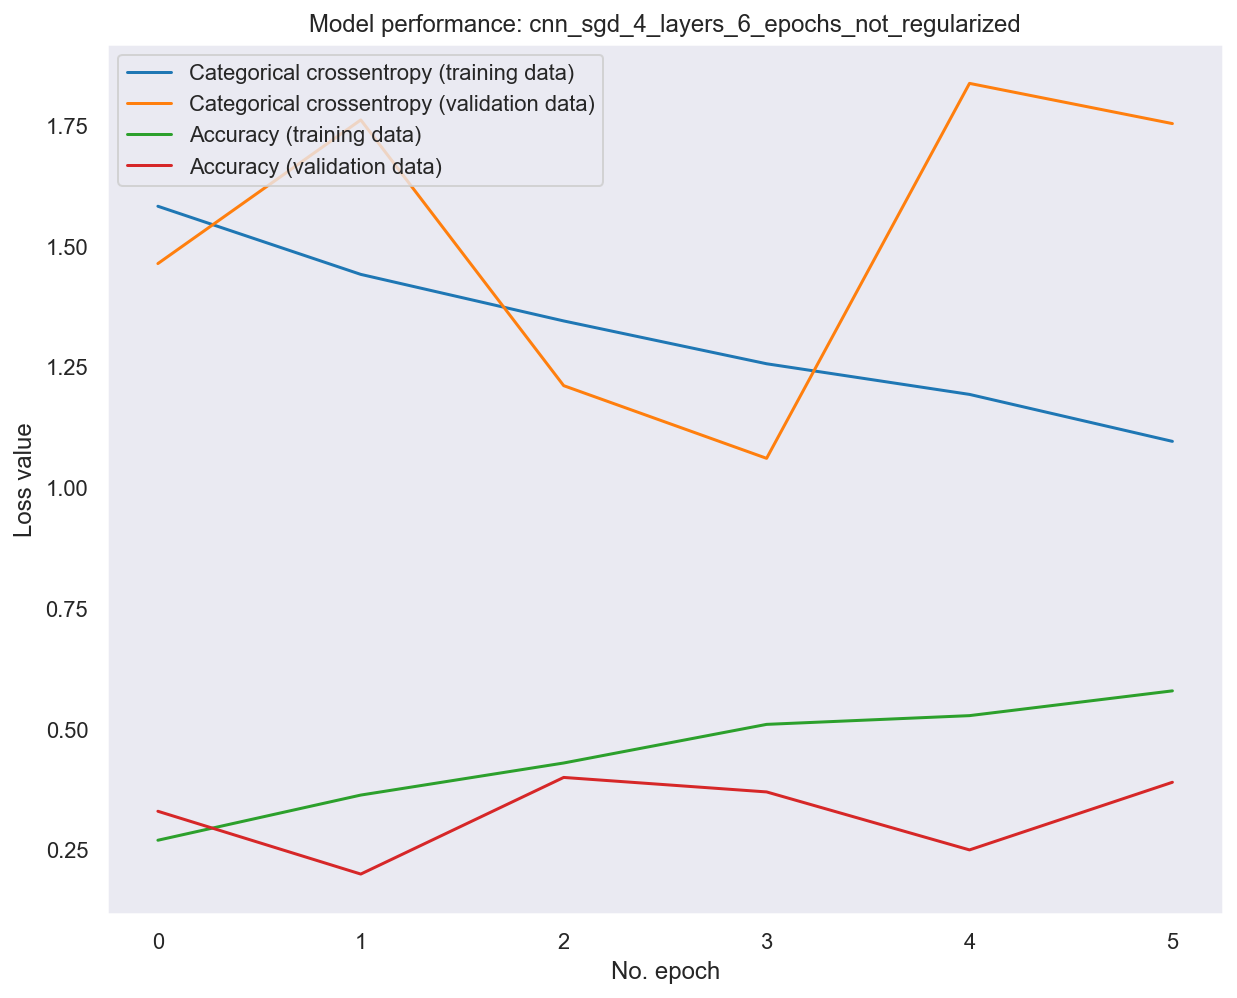

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    1.4635                    0.3300 1.5822                0.2700 0.0010   
1    1.7608                    0.2000 1.4411                0.3635 0.0010   
2    1.2108                    0.4000 1.3448                0.4299 0.0010   
3    1.0604                    0.3700 1.2562                0.5098 0.0010   
4    1.8365                    0.2500 1.1927                0.5279 0.0010   
5    1.7532                    0.3900 1.0955                0.5792 0.0010   

   epoch                                       name  
0      0  cnn_sgd_4_layers_6_epochs_not_regularized  
1      1  cnn_sgd_4_layers_6_epochs_not_regularized  
2      2  cnn_sgd_4_layers_6_epochs_not_regularized  
3      3  cnn_sgd_4_layers_6_epochs_not_regularized  
4      4  cnn_sgd_4_layers_6_epochs_not_regularized  
5      5  cnn_sgd_4_layers_6_epochs_not_regularized

In [117]:
params = {
    "learning_rate": 0.001,
    "optmizer": "sgd",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32],
    "batch_normalize": False,
    "dropouts": [None, None, None, None],
    "dense_input": [128],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> sgd
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
filters -> [8, 16, 32]
dropouts -> [None, None, None, None]
dense_input -> [128]
image_shape -> (120, 120)
kernel_shape_side -> 3
image_augmentation -> True
name -> cnn_sgd_4_layers_6_epochs_not_regularized
input_shape -> (30, 120, 120, 3)
SGD optimizer with learning rate:  0.001 False
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_______________

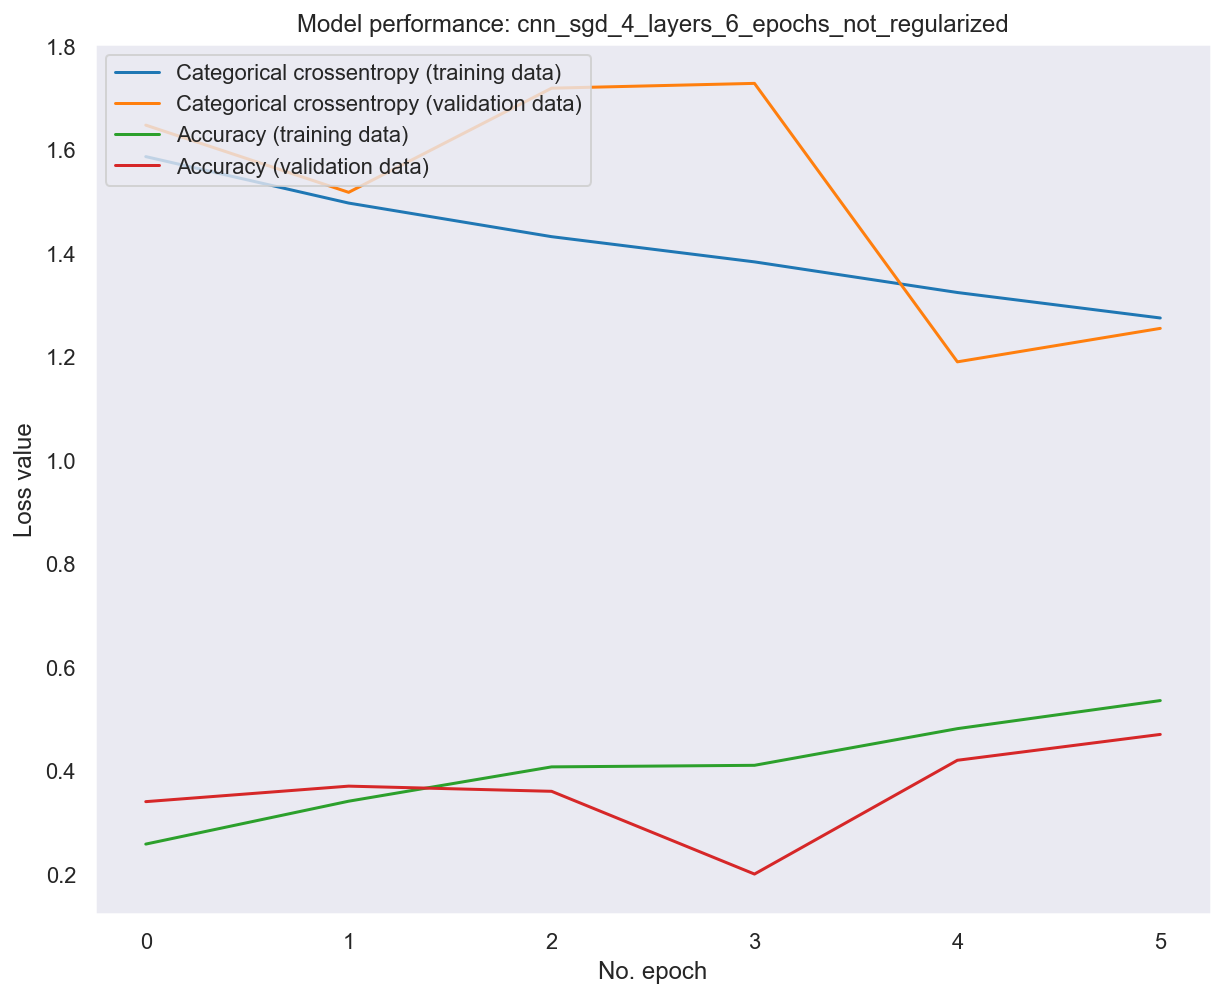

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    1.6480                    0.3400 1.5871                0.2579 0.0010   
1    1.5180                    0.3700 1.4973                0.3409 0.0010   
2    1.7194                    0.3600 1.4323                0.4072 0.0010   
3    1.7287                    0.2000 1.3836                0.4103 0.0010   
4    1.1903                    0.4200 1.3244                0.4811 0.0004   
5    1.2550                    0.4700 1.2751                0.5354 0.0004   

   epoch                                       name  
0      0  cnn_sgd_4_layers_6_epochs_not_regularized  
1      1  cnn_sgd_4_layers_6_epochs_not_regularized  
2      2  cnn_sgd_4_layers_6_epochs_not_regularized  
3      3  cnn_sgd_4_layers_6_epochs_not_regularized  
4      4  cnn_sgd_4_layers_6_epochs_not_regularized  
5      5  cnn_sgd_4_layers_6_epochs_not_regularized

In [166]:
params = {
    "learning_rate": 0.001,
    "optmizer": "sgd",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32],
    "batch_normalize": False,
    "dropouts": [None, None, None, None],
    "dense_input": [128],
    "image_shape": (120, 120),
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
filters -> [8, 16, 32]
dropouts -> [None, None, None, None]
dense_input -> [128]
image_shape -> (120, 120)
kernel_shape_side -> 3
name -> cnn_adam_4_layers_6_epochs_not_regularized
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 False
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_______________________________________

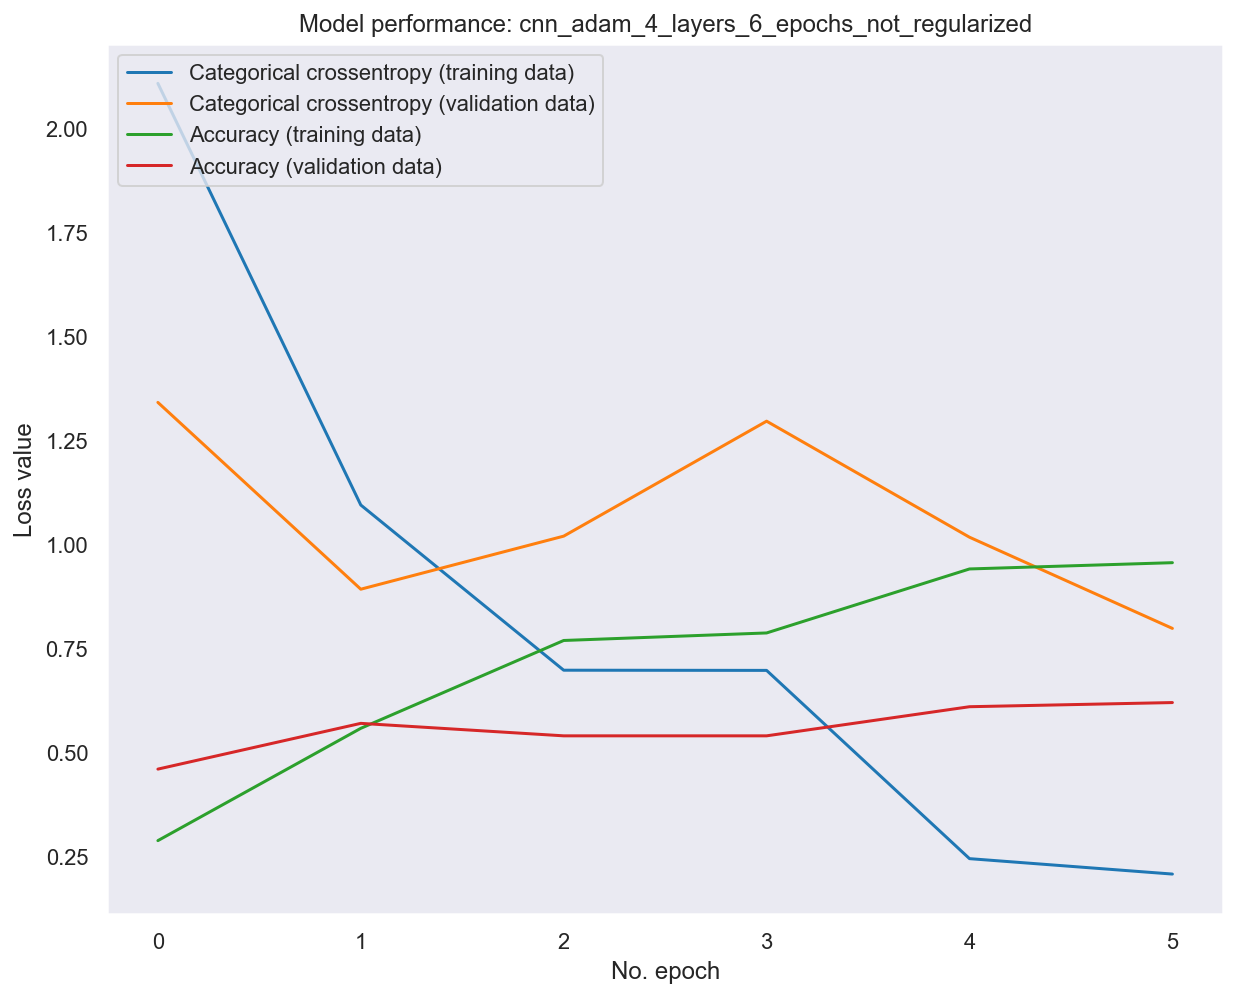

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    1.3416                    0.4600 2.1085                0.2881 0.0010   
1    0.8925                    0.5700 1.0949                0.5581 0.0010   
2    1.0201                    0.5400 0.6978                0.7692 0.0010   
3    1.2964                    0.5400 0.6973                0.7873 0.0010   
4    1.0174                    0.6100 0.2448                0.9412 0.0004   
5    0.7982                    0.6200 0.2077                0.9563 0.0004   

   epoch                                        name  
0      0  cnn_adam_4_layers_6_epochs_not_regularized  
1      1  cnn_adam_4_layers_6_epochs_not_regularized  
2      2  cnn_adam_4_layers_6_epochs_not_regularized  
3      3  cnn_adam_4_layers_6_epochs_not_regularized  
4      4  cnn_adam_4_layers_6_epochs_not_regularized  
5      5  cnn_adam_4_layers_6_epochs_not_regularized

In [119]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32],
    "batch_normalize": False,
    "dropouts": [None, None, None, None],
    "dense_input": [128],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

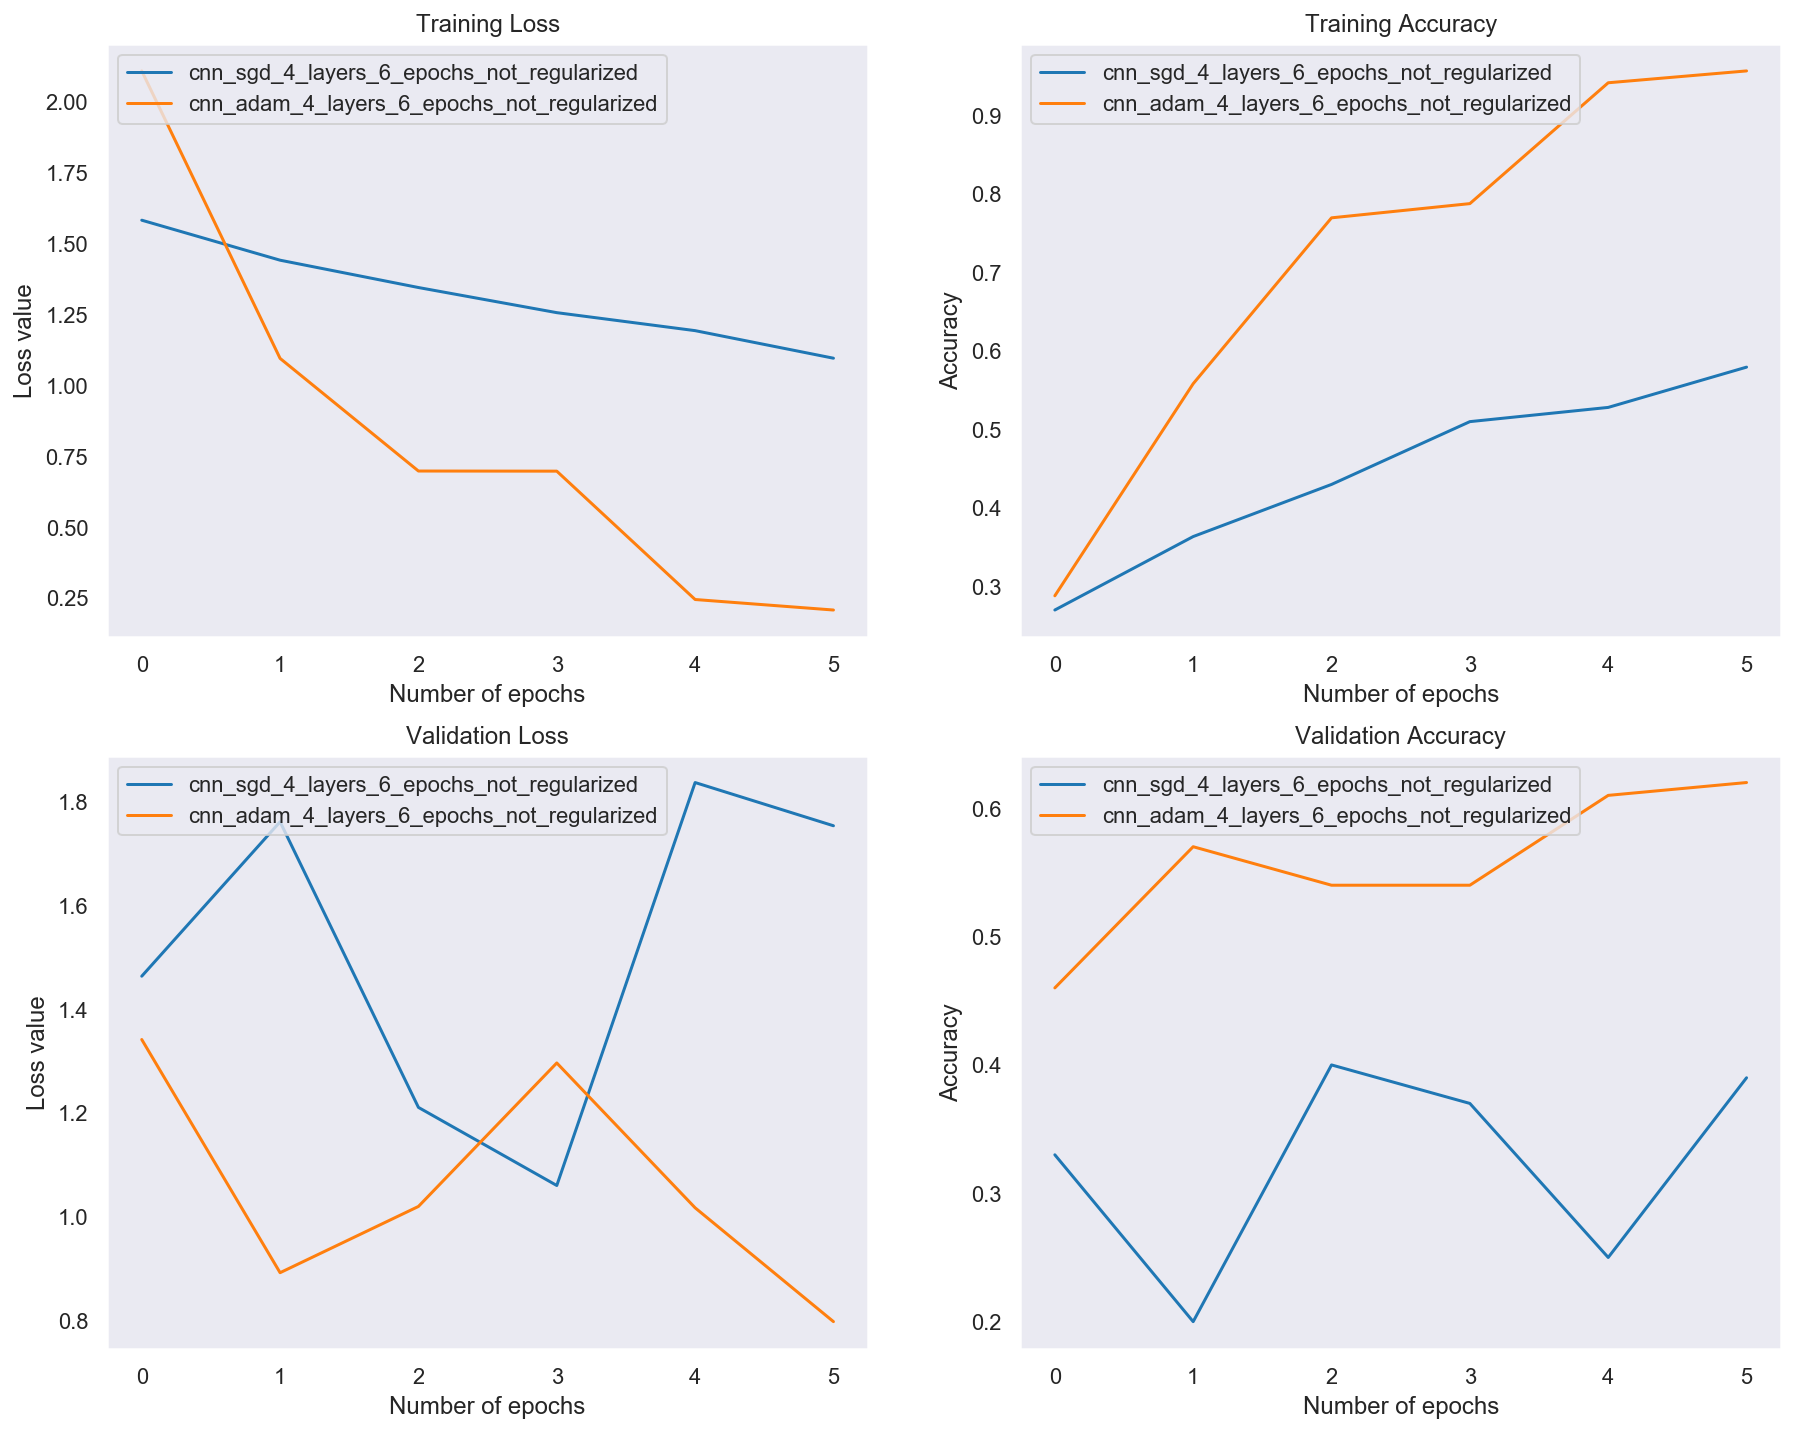

In [124]:
number_of_epochs = 6
first_model = 'cnn_sgd_4_layers_6_epochs_not_regularized'
second_model = 'cnn_adam_4_layers_6_epochs_not_regularized'

plot_graphs(first_model, second_model, number_of_epochs)

We can see that using `ADAM` optmizer significantly improves the accuracy. However, the difference between training accuracy and validation accuracy is too big which suggests overfitting of the data. Let us use regularization. We will use `BatchNormalization` and `Dropout` for regularization.

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [8, 16, 32]
dropouts -> [None, 0.25, 0.25, 0.25]
dense_input -> [128]
image_shape -> (120, 120)
kernel_shape_side -> 3
name -> cnn_adam_4_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 False
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 15, 60, 60, 8)     0         
_____________

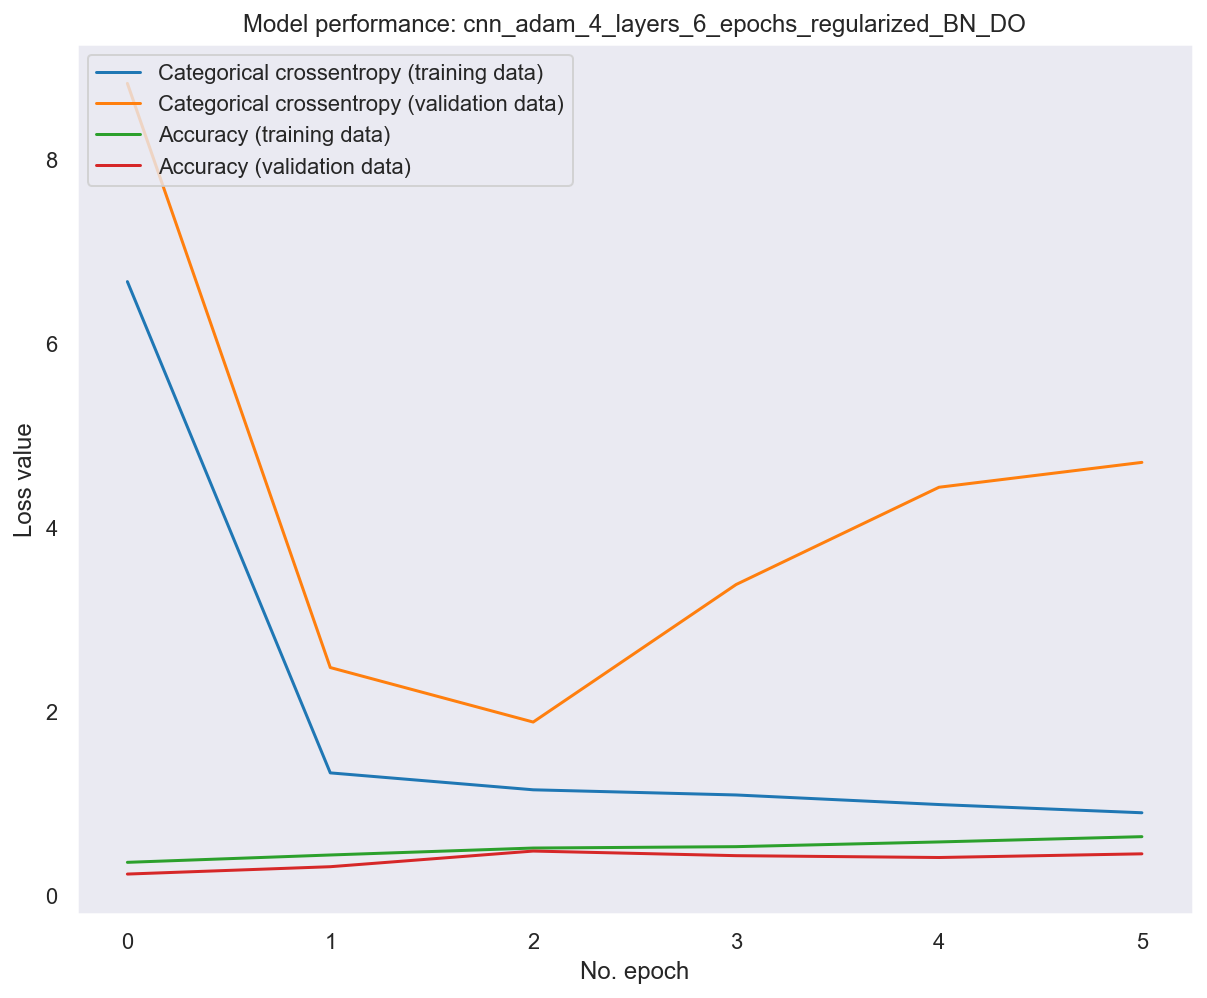

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    8.8234                    0.2300 6.6691                0.3575 0.0010   
1    2.4745                    0.3100 1.3298                0.4374 0.0010   
2    1.8822                    0.4800 1.1458                0.5128 0.0010   
3    3.3767                    0.4300 1.0896                0.5279 0.0010   
4    4.4340                    0.4100 0.9856                0.5792 0.0010   
5    4.7043                    0.4500 0.8963                0.6365 0.0004   

   epoch                                          name  
0      0  cnn_adam_4_layers_6_epochs_regularized_BN_DO  
1      1  cnn_adam_4_layers_6_epochs_regularized_BN_DO  
2      2  cnn_adam_4_layers_6_epochs_regularized_BN_DO  
3      3  cnn_adam_4_layers_6_epochs_regularized_BN_DO  
4      4  cnn_adam_4_layers_6_epochs_regularized_BN_DO  
5      5  cnn_adam_4_layers_6_epochs_regularized_BN_DO

In [128]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32],
    "batch_normalize": True,
    "dropouts": [None, .25, .25, .25],
    "dense_input": [128],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

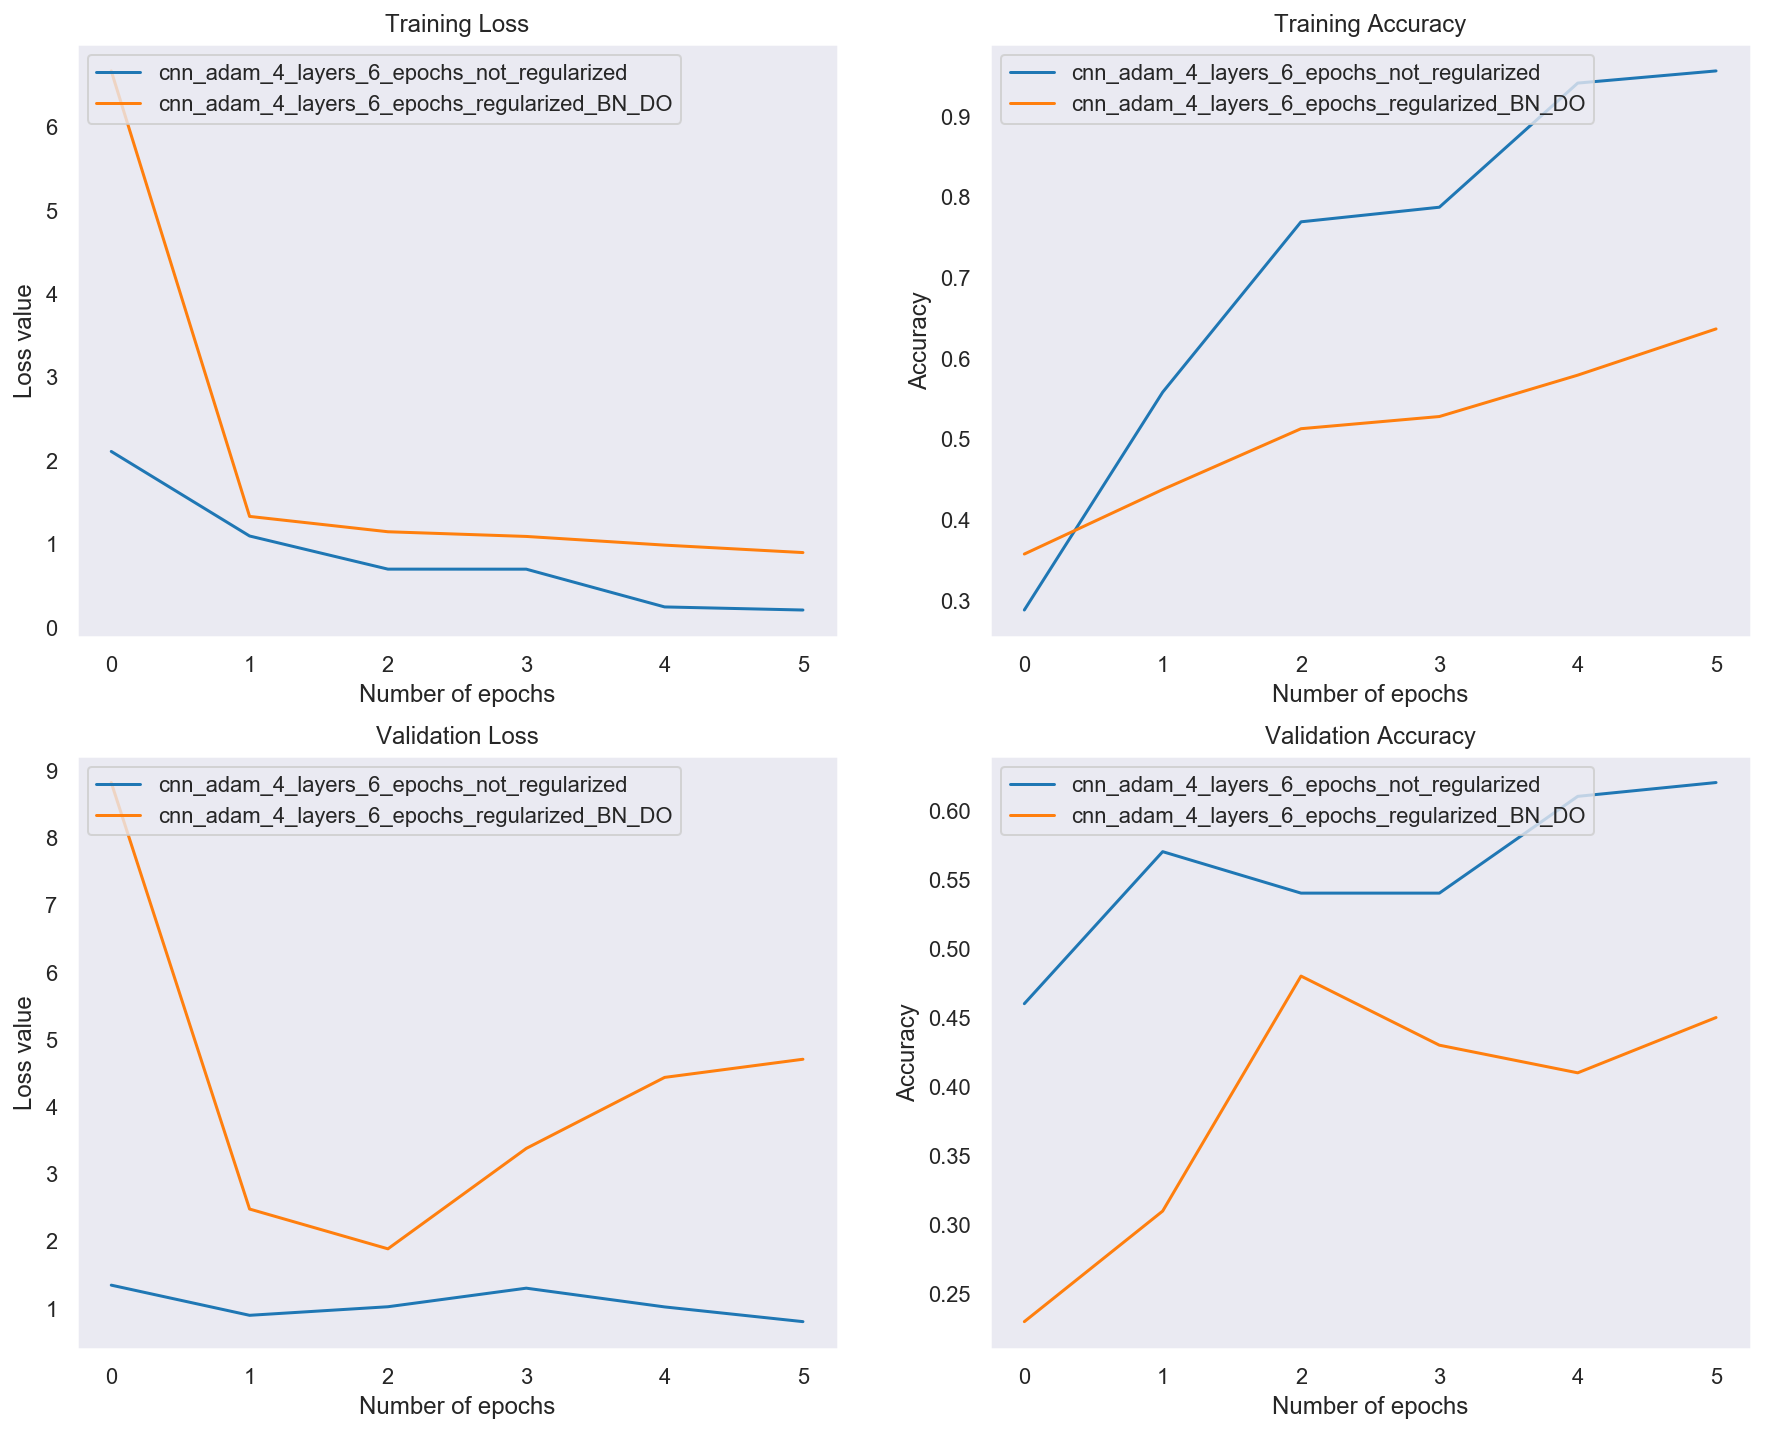

In [129]:
number_of_epochs = 6
first_model = 'cnn_adam_4_layers_6_epochs_not_regularized'
second_model = 'cnn_adam_4_layers_6_epochs_regularized_BN_DO'

plot_graphs(first_model, second_model, number_of_epochs)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, 0.25, 0.25, 0.25, 0.25, None]
dense_input -> [128, 64]
image_shape -> (120, 120)
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 False
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_34 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_19 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_34 (MaxPooling (None, 15, 60, 60, 8)     0  

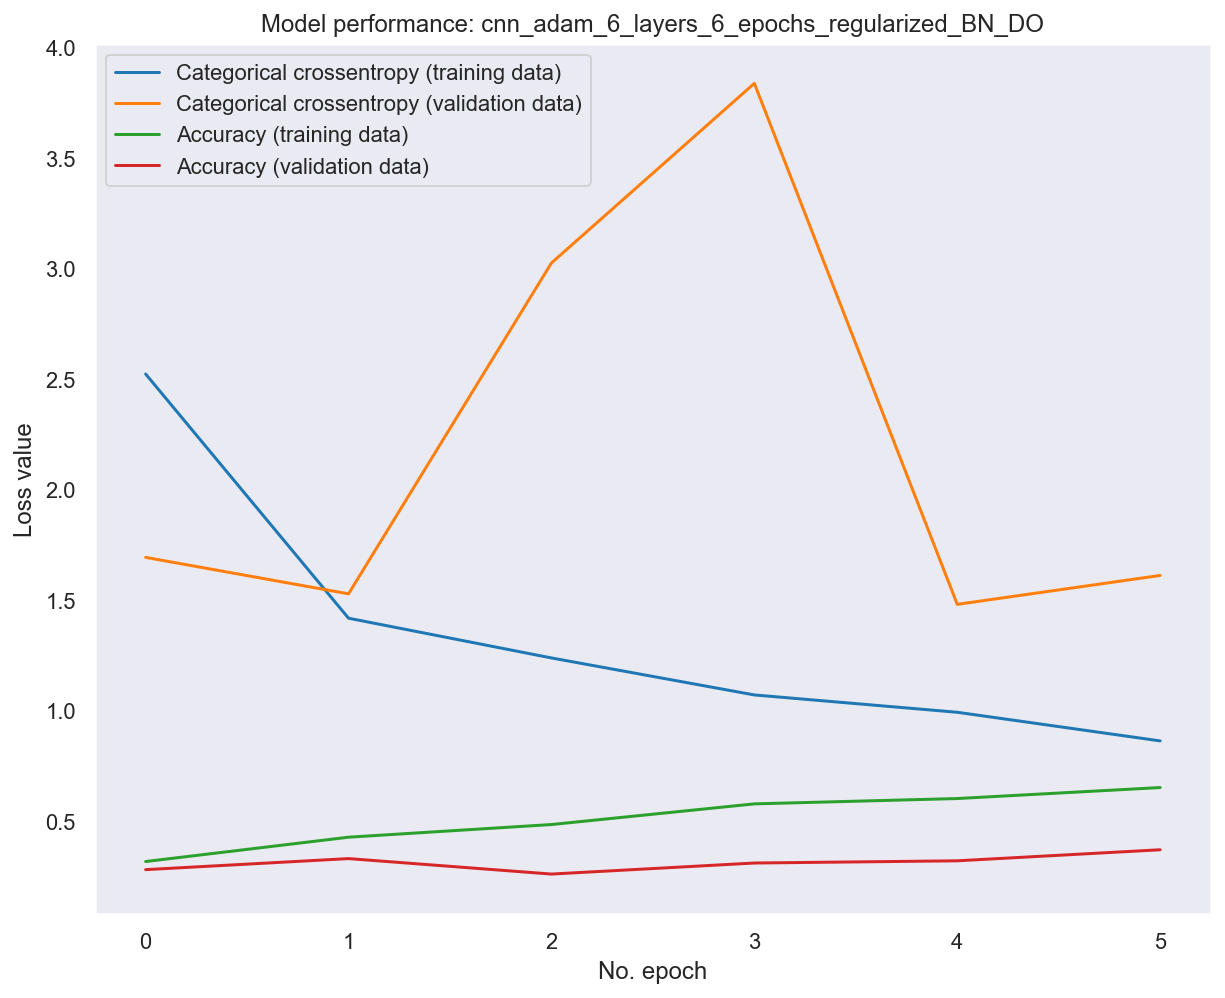

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    1.6933                    0.2800 2.5233                0.3167 0.0010   
1    1.5283                    0.3300 1.4180                0.4268 0.0010   
2    3.0258                    0.2600 1.2381                0.4842 0.0010   
3    3.8385                    0.3100 1.0707                0.5777 0.0010   
4    1.4806                    0.3200 0.9922                0.6018 0.0004   
5    1.6116                    0.3700 0.8627                0.6516 0.0004   

   epoch                                          name  
0      0  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
1      1  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
2      2  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
3      3  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
4      4  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
5      5  cnn_adam_6_layers_6_epochs_regularized_BN_DO

In [133]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32,64],
    "batch_normalize": True,
    "dropouts": [None, .25, .25, .25,.25,None],
    "dense_input": [128,64],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

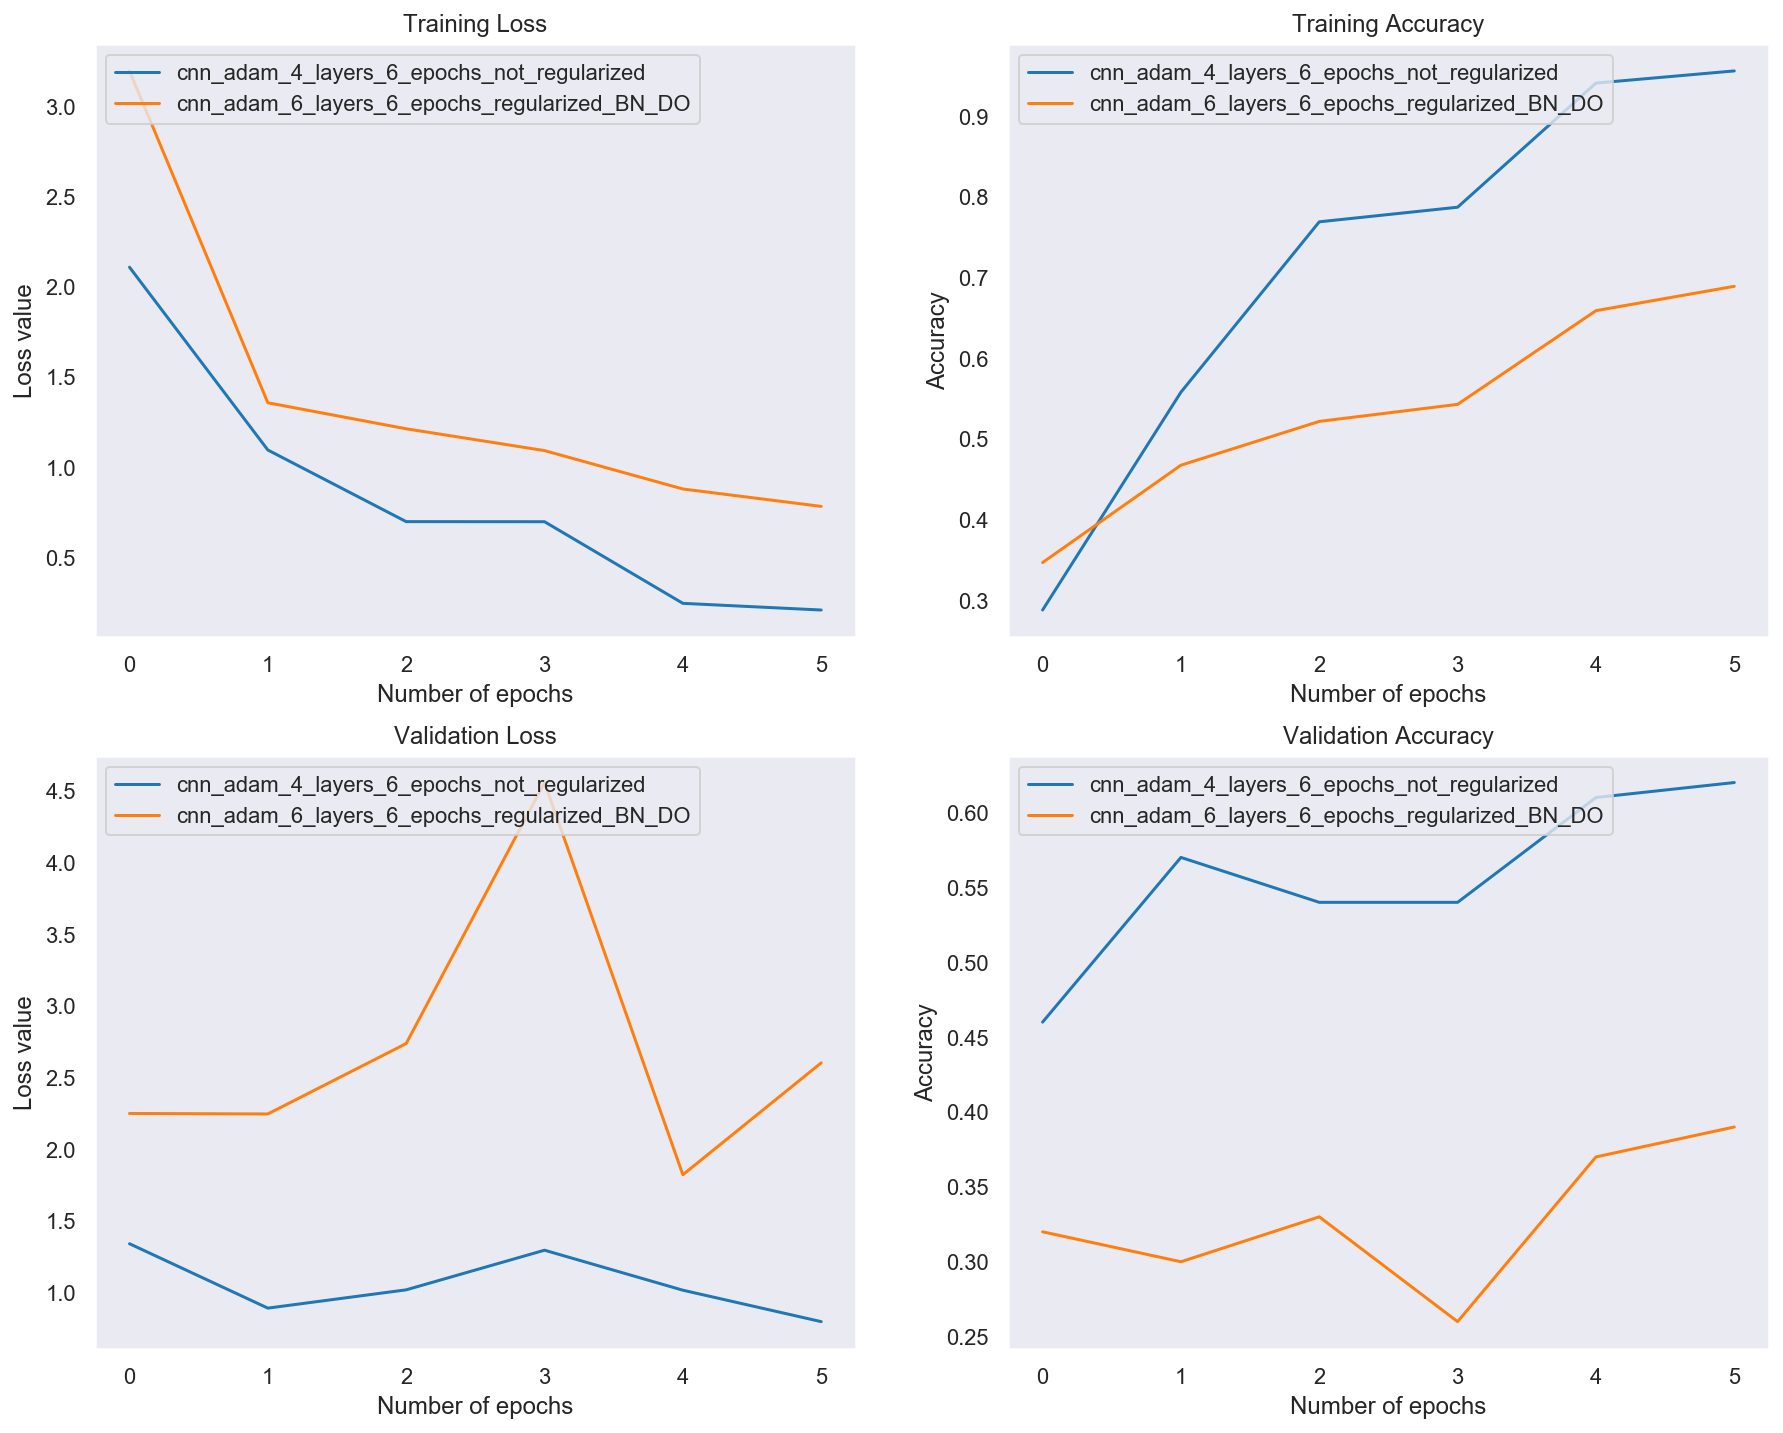

In [134]:
number_of_epochs = 6
first_model = 'cnn_adam_4_layers_6_epochs_not_regularized'
second_model = 'cnn_adam_6_layers_6_epochs_regularized_BN_DO'

plot_graphs(first_model, second_model, number_of_epochs)

We can see that the accuracy is not improving as it is supposed to. There is no steep drop in the loss. Let us increase the model filters and introduce learning rate decay.

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [16, 32, 64, 64]
dropouts -> [0.25, 0.25, 0.5, 0.25, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_38 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_23 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_38 (MaxPooling (

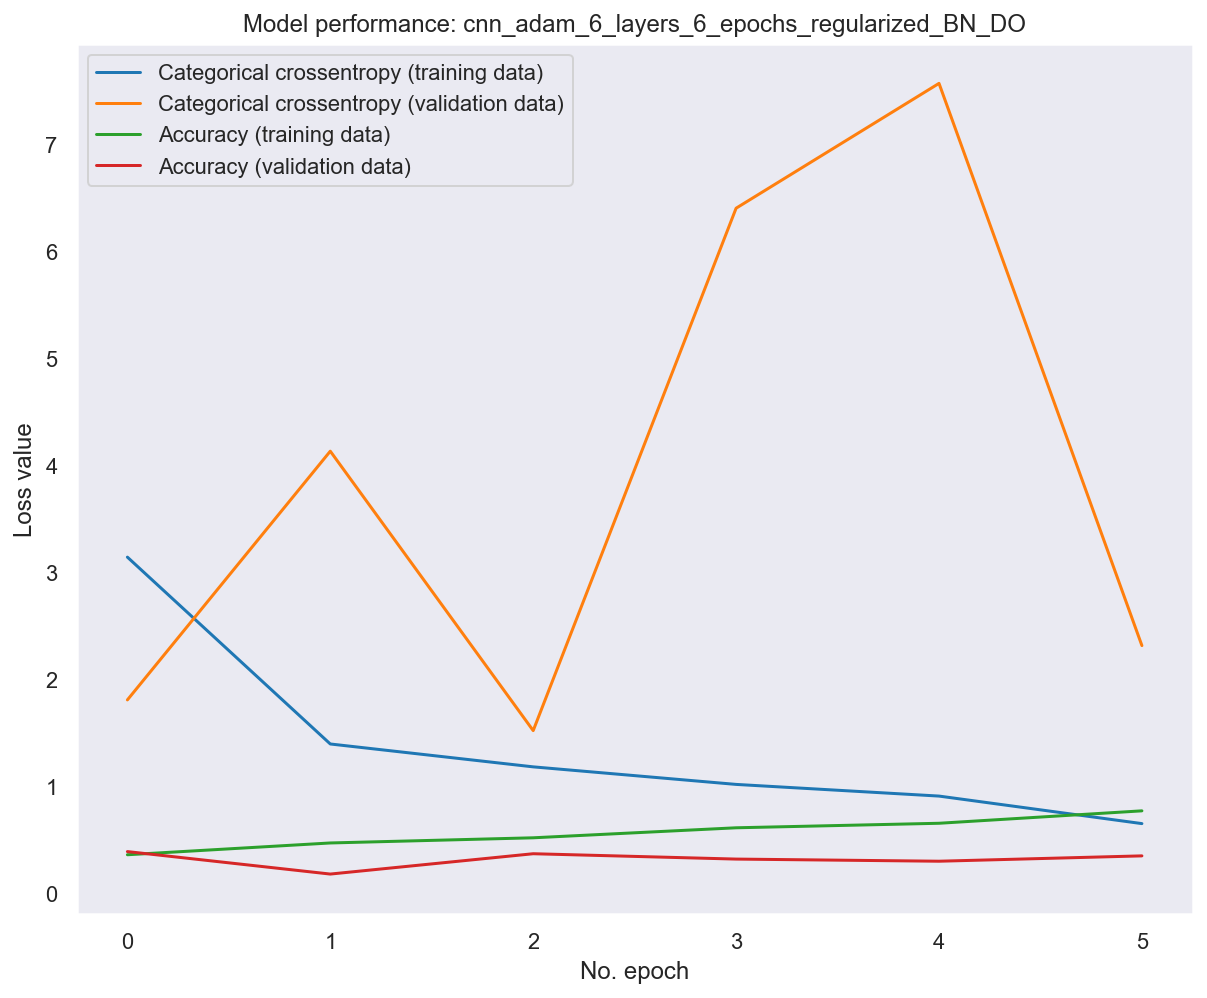

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    1.8069                    0.3900 3.1412                0.3605 0.0010   
1    4.1308                    0.1800 1.3954                0.4706 0.0010   
2    1.5203                    0.3700 1.1816                0.5189 0.0010   
3    6.4009                    0.3200 1.0177                0.6124 0.0010   
4    7.5673                    0.3000 0.9086                0.6546 0.0010   
5    2.3143                    0.3500 0.6514                0.7707 0.0004   

   epoch                                          name  
0      0  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
1      1  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
2      2  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
3      3  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
4      4  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
5      5  cnn_adam_6_layers_6_epochs_regularized_BN_DO

In [135]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [16, 32, 64,64],
    "batch_normalize": True,
    "dropouts": [.25, .25, .50, .25,.25,None],
    "dense_input": [256,128],
    "image_shape": (120, 120),
    "decay_learning_rate":True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 10
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [0.25, 0.25, 0.25, 0.25, 0.5, 0.5]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
augmentors -> [<function blur at 0x7fe3d2ad28c0>, <function scale at 0x7fe383a48680>, <function rotate at 0x7fe3d2ad2b00>]
name -> cnn_adam_6_layers_10_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_27 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 30, 

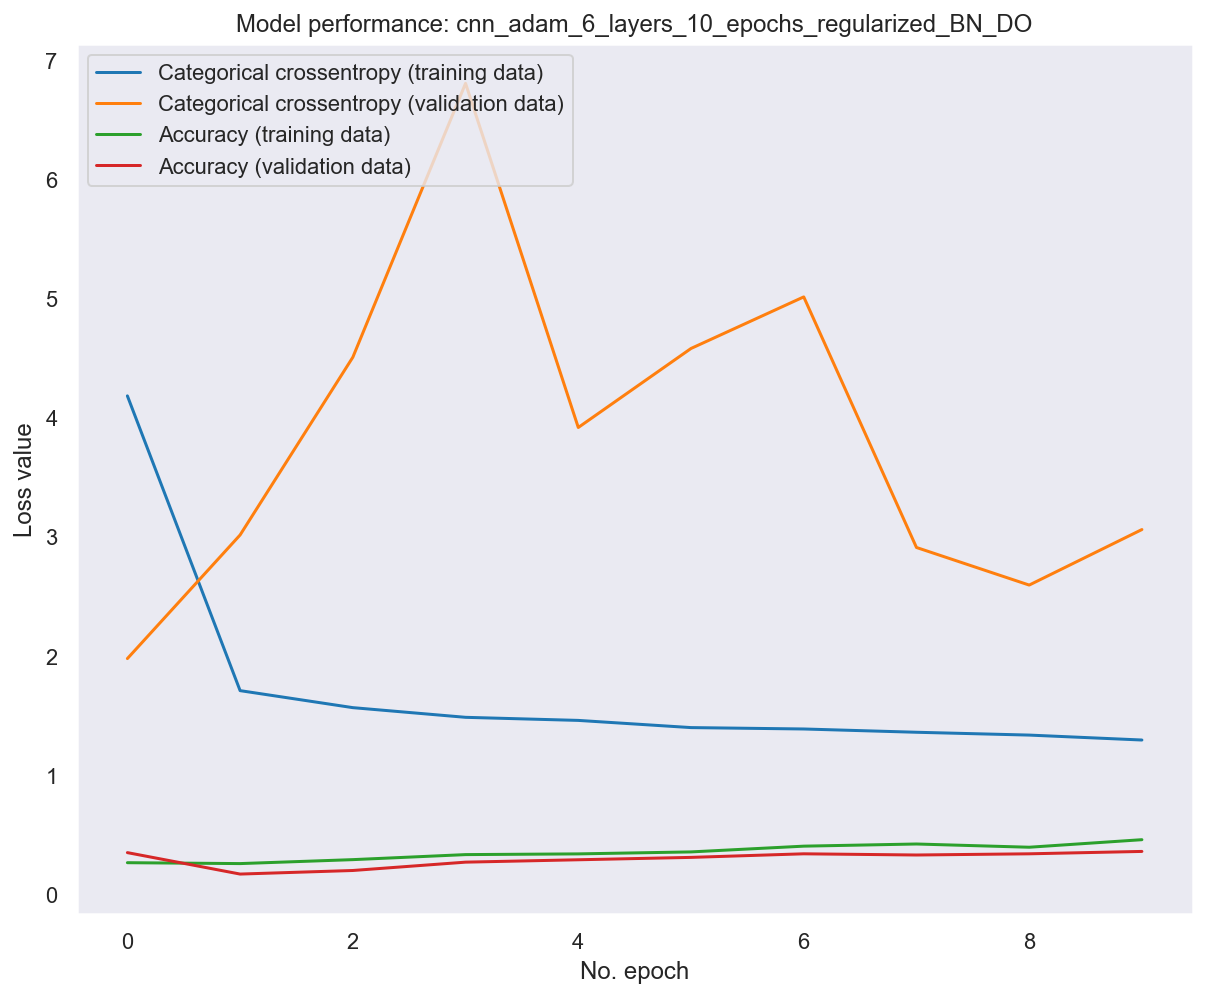

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    1.9784                    0.3500 4.1836                0.2655 0.0010   
1    3.0160                    0.1700 1.7095                0.2579 0.0010   
2    4.5076                    0.2000 1.5667                0.2911 0.0010   
3    6.8061                    0.2700 1.4855                0.3333 0.0004   
4    3.9180                    0.2900 1.4597                0.3394 0.0004   
5    4.5812                    0.3100 1.3993                0.3560 0.0002   
6    5.0141                    0.3400 1.3876                0.4042 0.0002   
7    2.9109                    0.3300 1.3601                0.4223 0.0001   
8    2.5955                    0.3400 1.3364                0.3952 0.0001   
9    3.0615                    0.3600 1.2950                0.4585 0.0000   

   epoch                                           name  
0      0  cnn_adam_6_layers_10_epochs_regularized_BN_DO  
1      1  cnn_adam_6_layers_10_epochs_regularized_BN_DO  
2      2  cnn_adam_6_layers_10_epochs_regularized_BN_DO  
3      3  cnn_adam_6_layers_10_epochs_regularized_BN_DO  
4      4  cnn_adam_6_layers_10_epochs_regularized_BN_DO  
5      5  cnn_adam_6_layers_10_epochs_regularized_BN_DO  
6      6  cnn_adam_6_layers_10_epochs_regularized_BN_DO  
7      7  cnn_adam_6_layers_10_epochs_regularized_BN_DO  
8      8  cnn_adam_6_layers_10_epochs_regularized_BN_DO  
9      9  cnn_adam_6_layers_10_epochs_regularized_BN_DO

In [217]:
# Not use it

params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 10,
    "filters": [8, 16, 32, 64],
    "batch_normalize": True,
    "dropouts": [.25, .25, .25, .25, .50, .50],
    "dense_input": [256, 128],
    "image_shape": (120, 120),
    "decay_learning_rate": True,
    "augmentors": [blur, scale, rotate]
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

In [208]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (5, 27),
    "model_name": "cnn",
    "num_epochs": 15,
    "filters": [8, 16, 32, 64],
    "batch_normalize": True,
    "dropouts": [None, .25, .25, .50, .25, None],
    "dense_input": [256, 128],
    "image_shape": (120, 120),
    "decay_learning_rate": True,
    "image_augmentation": True

}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
num_epochs -> 15
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, 0.25, 0.25, 0.5, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_15_epochs_regularized_BN_DO
input_shape -> (22, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 22, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 22, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 11, 60, 60, 8)     0 

TypeError: generator() got an unexpected keyword argument 'image_augmentation'

In [170]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32, 64, 128],
    "batch_normalize": True,
    "dropouts": [None, .25, .25, .50, .25, .25, None],
    "dense_input": [256, 128],
    "image_shape": (120, 120),
    "decay_learning_rate": True,
    "image_augmentation": True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [32, 32, 64, 64]
dropouts -> [None, None, 0.25, 0.5, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
image_augmentation -> True
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_58 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_43 (Batc (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max

KeyboardInterrupt: 

In [51]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [16, 32, 64,128],
    "batch_normalize": True,
    "dropouts": [None, .25, .50, .50,.25,None],
    "dense_input": [256,128],
    "image_shape": (120, 120),
    "decay_learning_rate":True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [16, 32, 64, 128]
dropouts -> [None, 0.25, 0.5, 0.5, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_16 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 15, 60, 60, 16)  

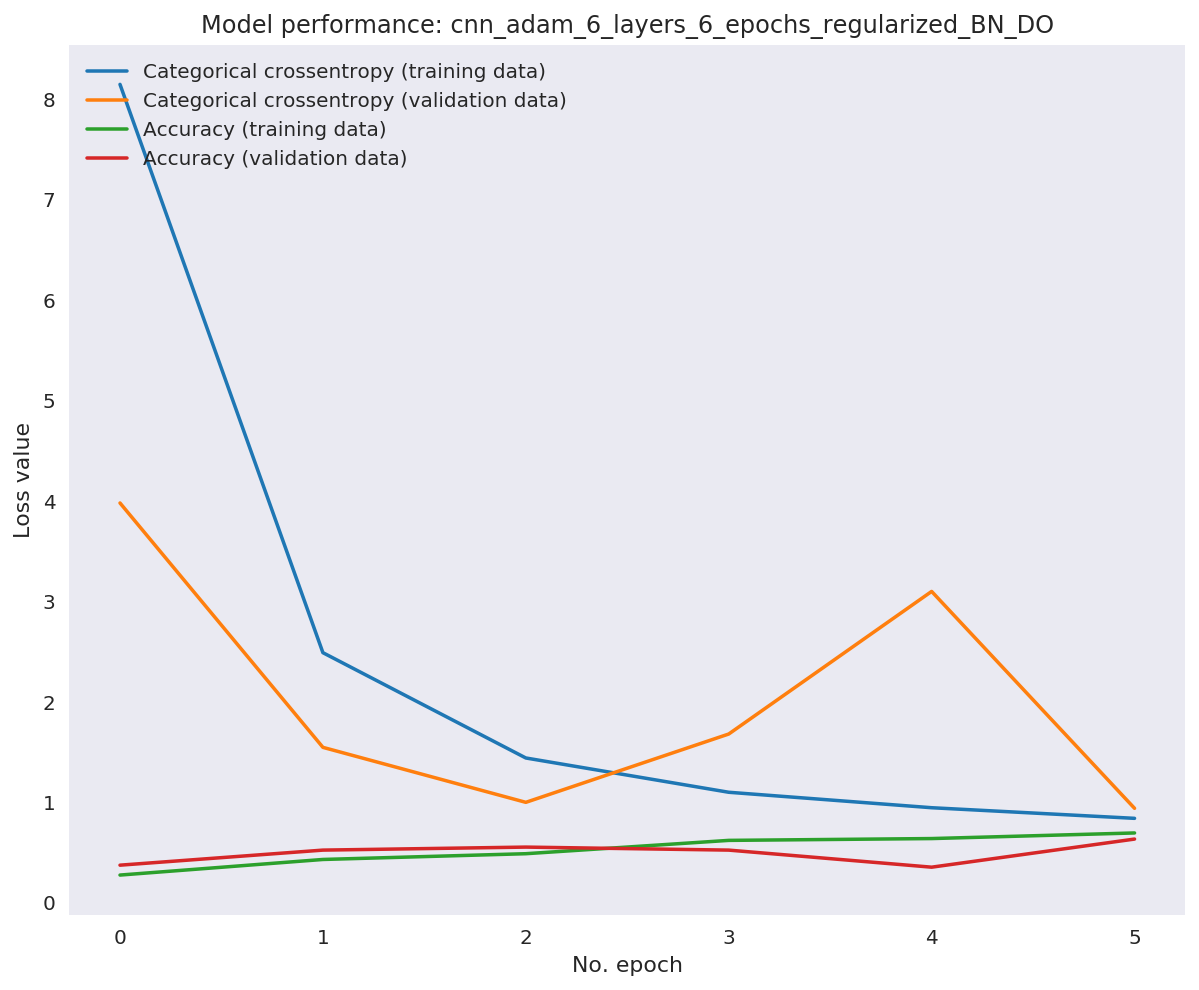

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    3.9767                    0.3700 8.1454                0.2715 0.0010   
1    1.5433                    0.5200 2.4860                0.4268 0.0010   
2    0.9958                    0.5500 1.4375                0.4842 0.0010   
3    1.6760                    0.5200 1.0961                0.6169 0.0010   
4    3.0960                    0.3500 0.9421                0.6350 0.0010   
5    0.9362                    0.6300 0.8364                0.6908 0.0004   

   epoch                                          name  
0      0  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
1      1  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
2      2  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
3      3  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
4      4  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
5      5  cnn_adam_6_layers_6_epochs_regularized_BN_DO

In [52]:
df = run_model(model, model_param)
collect_stats(df)

In [53]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32,64],
    "batch_normalize": True,
    "dropouts": [None, None, .25, .25,.25,None],
    "dense_input": [256,128],
    "image_shape": (120, 120),
    "decay_learning_rate":True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, None, 0.25, 0.25, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_20 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 15, 60, 60, 8)   

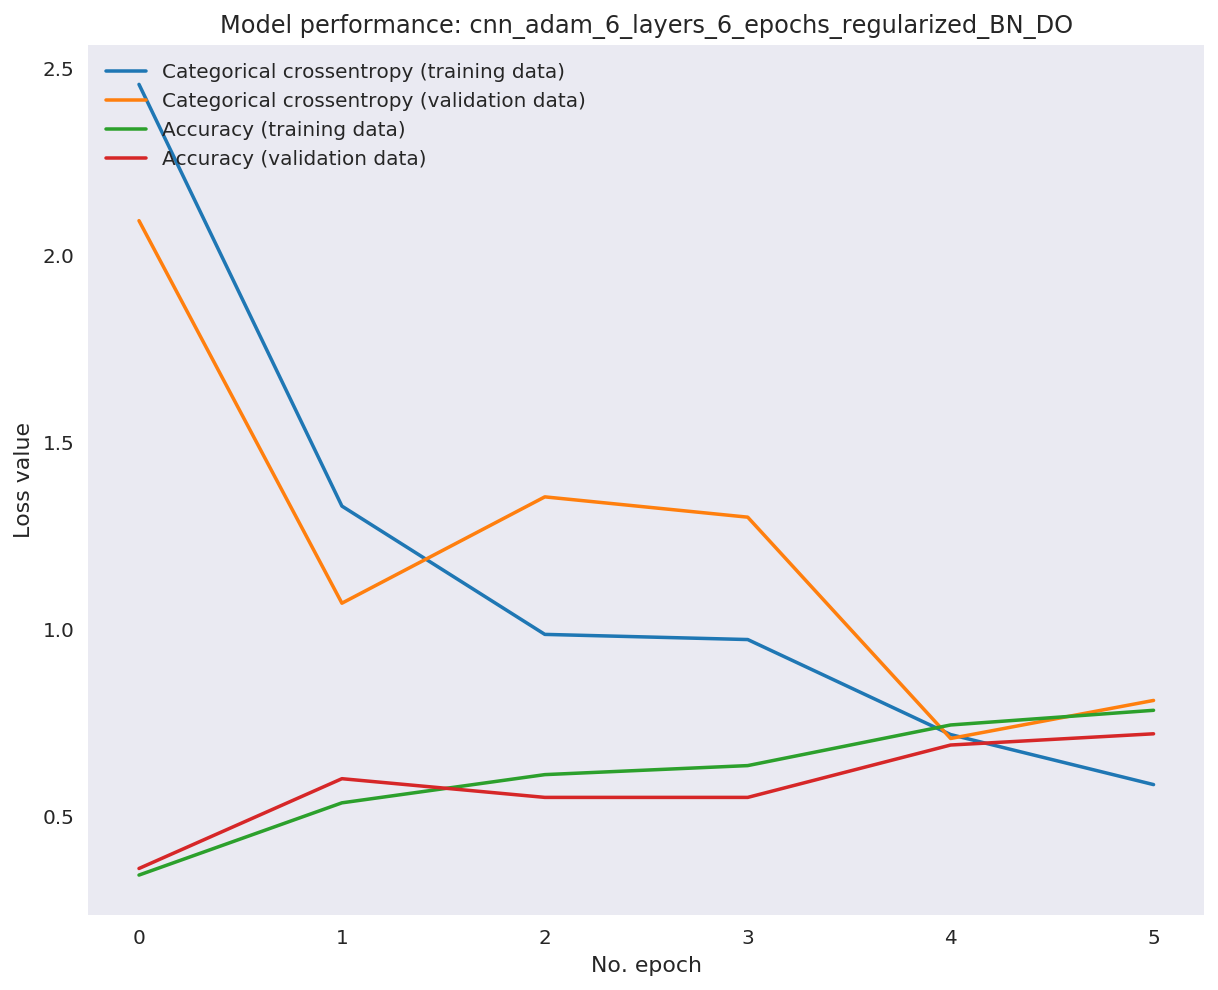

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    2.0916                    0.3600 2.4559                0.3424 0.0010   
1    1.0691                    0.6000 1.3287                0.5354 0.0010   
2    1.3533                    0.5500 0.9857                0.6109 0.0010   
3    1.2991                    0.5500 0.9719                0.6350 0.0010   
4    0.7075                    0.6900 0.7179                0.7436 0.0004   
5    0.8092                    0.7200 0.5842                0.7828 0.0004   

   epoch                                          name  
0      0  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
1      1  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
2      2  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
3      3  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
4      4  cnn_adam_6_layers_6_epochs_regularized_BN_DO  
5      5  cnn_adam_6_layers_6_epochs_regularized_BN_DO

In [54]:
df = run_model(model, model_param)
collect_stats(df)

In [55]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32,64],
    "batch_normalize": True,
    "dropouts": [None, None, .25, .25,.25,None],
    "dense_input": [256,128],
    "image_shape": (100, 100),
    "decay_learning_rate":True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)

In [ ]:
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, None, 0.25, 0.25, 0.25, None]
dense_input -> [256, 128]
image_shape -> (100, 100)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 100, 100, 3)
ADAM optimizer with learning rate:  0.001 True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_30 (Conv3D)           (None, 30, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 100, 100, 8)   32        
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 15, 50, 50, 8)   

In [36]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (4, 28),
    "model_name": "cnn",
    "num_epochs": 20,
    "filters": [8, 16, 32,64],
    "batch_normalize": True,
    "dropouts": [None, None, .25, .25,.25,None],
    "dense_input": [256,128],
    "image_shape": (120, 120),
    "decay_learning_rate":True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)

In [37]:
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
num_epochs -> 20
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, None, 0.25, 0.25, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_20_epochs_regularized_BN_DO
input_shape -> (24, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 24, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 60, 60, 8)     0         
_____

KeyboardInterrupt: 

Reference: 
- https://machinelearningmastery.com/cnn-long-short-term-memory-networks/
- https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00
- https://github.com/keras-team/keras/issues/3945

In [260]:
def create_cnn_rnn_model(model_param):
    assert model_param.is_rnn, "The params should be for RNN"
    model = Sequential()
    for index, f in enumerate(model_param.filters):
        if index == 0:
            model.add(
                TimeDistributed(Conv2D(f,
                                       kernel_size=(3, 3),
                                       activation='relu',
                                       strides=(2, 2),
                                       kernel_initializer='he_uniform',
                                       padding='same'),
                                input_shape=model_param.input_shape))
        else:
            model.add(
                TimeDistributed(
                    Conv2D(f,
                           kernel_size=(3, 3),
                           activation='relu',
                           strides=(2, 2),
                           kernel_initializer='he_uniform',
                           padding='same')))
        model.add(
            TimeDistributed(
                Conv2D(f,
                       kernel_size=(3, 3),
                       activation='relu',
                       strides=(2, 2),
                       kernel_initializer='he_uniform',
                       padding='same')))
        if model_param.batch_normalize:
            model.add(BatchNormalization())

        model.add(
            TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
        if model_param.dropouts[index]:
            model.add(Dropout(model_param.dropouts[index]))

    model.add(TimeDistributed(Flatten()))
    for index, d in enumerate(model_param.rnn_layers):
        if model_param.rnn_layer_type == 'LSTM':
            model.add(LSTM(d, return_sequences=True))
        else:
            model.add(GRU(d, return_sequences=True))

        dropout_index = len(model_param.filters) + index
        if model_param.batch_normalize and dropout_index < len(
                model_param.dense_input):
            model.add(BatchNormalization())
        if model_param.dropouts[dropout_index]:
            model.add(Dropout(model_param.dropouts[dropout_index]))
    
    model.add(Flatten())
    
    for index, d in enumerate(model_param.dense_input):
        model.add(Dense(d, activation='relu', kernel_initializer='he_uniform'))
        dropout_index = len(model_param.filters) + len(
            model_param.rnn_layers) + index
        if model_param.batch_normalize and dropout_index < len(
                model_param.dense_input):
            model.add(BatchNormalization())
        if model_param.dropouts[dropout_index]:
            model.add(Dropout(model_param.dropouts[dropout_index]))

    model.add(Dense(5, activation='softmax'))
    return model

In [261]:
params = {
    "learning_rate": 0.001,
    "optmizer": "sgd",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn_rnn",
    "num_epochs": 6,
    "filters": [16, 16, 32],
    "batch_normalize": False,
    "dropouts": [None, None, None, None, None],
    "dense_input": [128],
    "image_shape": (120, 120),
    "rnn_layers": [512],
    "rnn_layer_type": "LSTM"
}
model_param = ModelParam(params)
model = create_cnn_rnn_model(model_param)

Model Params: 
learning_rate -> 0.001
optmizer -> sgd
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
filters -> [16, 16, 32]
dropouts -> [None, None, None, None, None]
dense_input -> [128]
image_shape -> (120, 120)
rnn_layer_type -> LSTM
rnn_layers -> [256]
name -> cnn_rnn_sgd_4_layers_6_epochs_not_regularized
is_rnn -> True
input_shape -> (30, 120, 120, 3)
SGD optimizer with learning rate:  0.001
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_112 (TimeDi (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_113 (TimeDi (None, 30, 30, 30, 16)    2320      
_________________________________________________________________
time_distributed_114 (TimeDi (None, 30, 15, 15, 16)    0         
_

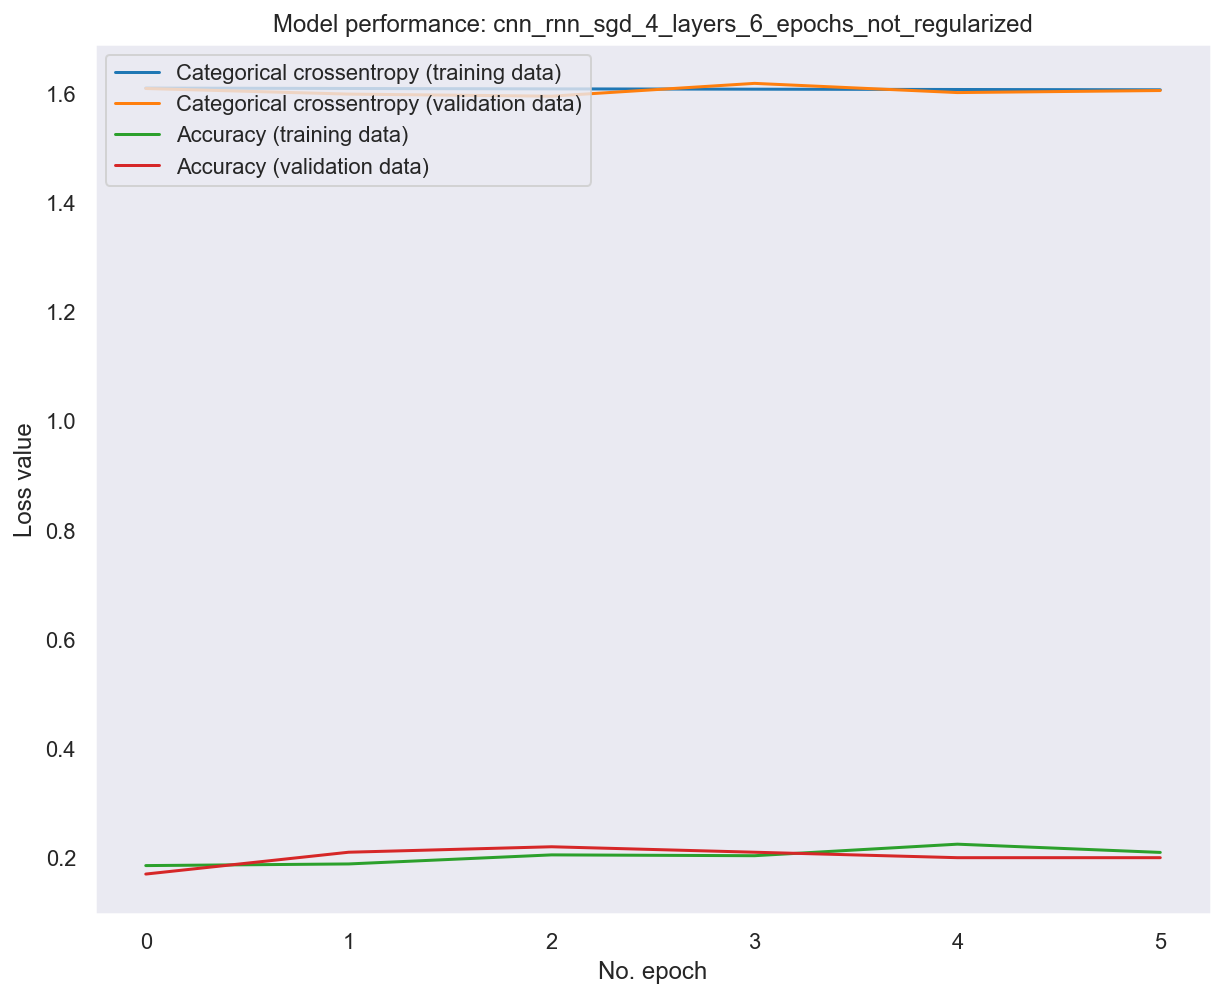

val_loss  val_categorical_accuracy   loss  categorical_accuracy     lr  \
0    1.6087                    0.1700 1.6094                0.1855 0.0010   
1    1.5984                    0.2100 1.6087                0.1885 0.0010   
2    1.5946                    0.2200 1.6080                0.2051 0.0010   
3    1.6181                    0.2100 1.6074                0.2036 0.0010   
4    1.6012                    0.2000 1.6069                0.2247 0.0010   
5    1.6050                    0.2000 1.6063                0.2097 0.0004   

   epoch                                           name  
0      0  cnn_rnn_sgd_4_layers_6_epochs_not_regularized  
1      1  cnn_rnn_sgd_4_layers_6_epochs_not_regularized  
2      2  cnn_rnn_sgd_4_layers_6_epochs_not_regularized  
3      3  cnn_rnn_sgd_4_layers_6_epochs_not_regularized  
4      4  cnn_rnn_sgd_4_layers_6_epochs_not_regularized  
5      5  cnn_rnn_sgd_4_layers_6_epochs_not_regularized

In [262]:
df = run_model(model, model_param)
collect_stats(df)

In [265]:
params = {
    "learning_rate": 0.001,
    "optmizer": "sgd",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn_rnn",
    "num_epochs": 6,
    "filters": [16, 32, 32],
    "batch_normalize": False,
    "dropouts": [None, None, None, None, None],
    "dense_input": [64],
    "image_shape": (120, 120),
    "rnn_layers": [256],
    "rnn_layer_type": "LSTM"
}
model_param = ModelParam(params)
model = create_cnn_rnn_model(model_param)

In [266]:
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> sgd
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
filters -> [16, 32, 32]
dropouts -> [None, None, None, None, None]
dense_input -> [64]
image_shape -> (120, 120)
rnn_layer_type -> LSTM
rnn_layers -> [256]
name -> cnn_rnn_sgd_4_layers_6_epochs_not_regularized
is_rnn -> True
input_shape -> (30, 120, 120, 3)
SGD optimizer with learning rate:  0.001
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_132 (TimeDi (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_133 (TimeDi (None, 30, 30, 30, 16)    2320      
_________________________________________________________________
time_distributed_134 (TimeDi (None, 30, 15, 15, 16)    0         
__

KeyboardInterrupt: 